This notebook contains differential expression and GO-term & pathway enrichment analysis of the Neuronal differention patient dataset.

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import batchglm
import diffxpy.api as de
import patsy as pat
import logging, warnings
from batchglm.pkg_constants import TF_CONFIG_PROTO

/home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/icb/malte.luecken/anaconda3/envs/sc-tutorial/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)]

In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()
de.__version__

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 35)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="tensorflow")

scanpy==1.4.3+116.g0075c62 anndata==0.6.22.post2.dev80+g72c2bde umap==0.3.9 numpy==1.17.2 scipy==1.3.0 pandas==0.24.1 scikit-learn==0.21.3 statsmodels==0.10.0rc2 python-igraph==0.7.1 louvain==0.6.1


'v0.6.1'

In [3]:
#Set number of threads
TF_CONFIG_PROTO.inter_op_parallelism_threads = 1
TF_CONFIG_PROTO.intra_op_parallelism_threads = 12


In [4]:
#User inputs
folder = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/'

adata_final = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_final.h5ad'

de_output_pickle = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_de_results_louvain_final_diffxpy_sf.pkl'

de_output_pickle_bulk = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_de_results_louvain_final_diffxpy_sf_bulk_like.pkl'

de_output_pickle_coarse = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_de_results_louvain_final_coarse_diffxpy_sf.pkl'

de_output_base = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_sf_de_results_louvain_final'

enrich_output_base = '/storage/groups/ml01/workspace/malte.luecken/2019_wurst_demuxlet/Main_study/processed_data/ipsc_ipd_patients_sf_enrich_results_louvain_final'

# Read the data

In [5]:
adata = sc.read(adata_final)

In [6]:
adata

AnnData object with n_obs × n_vars = 30557 × 24920 
    obs: 'Demux_state', 'Donor', 'Lane', 'Number of genes', 'Total counts', 'age', 'condition', 'donor', 'gender', 'log_counts', 'mt_frac', 'n_counts', 'n_genes', 'size_factors', 'total_counts', 'years_of_illness', 'S_score', 'G2M_score', 'phase', 'louvain_r1', 'louvain_r0.5', 'louvain_r0.2', 'score', 'louvain_r0.2_0_sub', 'louvain_r0.2_0_4_sub', 'louvain_r0.2_0_3_sub', 'dpt_pseudotime', 'louvain_r0.2_noCC', 'louvain_final', 'Ferroptosis_pos_raw', 'Ferroptosis_pos_corr', 'Ferroptosis_neg_raw', 'Ferroptosis_neg_corr', 'Apoptosis_pos_raw', 'Apoptosis_pos_corr', 'Apoptosis_neg_raw', 'Apoptosis_neg_corr', 'Necroptosis_pos_raw', 'Necroptosis_pos_corr', 'Autophagy_pos_raw', 'Autophagy_pos_corr', 'Pathanatos_pos_raw', 'Pathanatos_pos_corr', 'louvain_final_abbrev'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Donor_colors', 'condition_colors', 'gender_colors', 'louvain', 'louvain_final_abbrev_colors', 'louva

# Check the data

In [7]:
np.mean(adata.layers['counts'].astype(int) != adata.layers['counts'])

0.0

Counts are actually all integer counts.

In [8]:
adata.obs.condition.value_counts()

Parkinson    18887
Control      11670
Name: condition, dtype: int64

In [9]:
adata.obs.groupby(['louvain_final'])['condition'].value_counts()

louvain_final     condition
Glial precursors  Parkinson     838
                  Control       153
Immature neurons  Parkinson     399
                  Control       105
NCSC              Control      2753
                  Parkinson    2251
NSC1a             Parkinson    4848
                  Control      3845
NSC1b             Parkinson    4339
                  Control      1860
NSC2a             Parkinson    3676
                  Control      1971
NSC2b             Parkinson    1471
                  Control       452
Apop. NCSC        Control       110
                  Parkinson     101
Apop. NSC         Parkinson     964
                  Control       421
Name: condition, dtype: int64

Note:
- General imbalance between Parkinson and control cell numbers
- imbalance strongly represented in 'NSC (Shh)', 'NSC (Shh, G2M)', 'Glial precursors (myelinating)', and 'immature neurons' clusters
- more control cells than expected in 'NCSC (low MT)' and 'NSC (early)'

In [10]:
adata.obs['louvain_final_coarse'] = ['NSC1' if ct.startswith('NSC1') else 'NSC2' if ct.startswith('NSC2') else ct for ct in adata.obs.louvain_final]

... storing 'louvain_final_coarse' as categorical


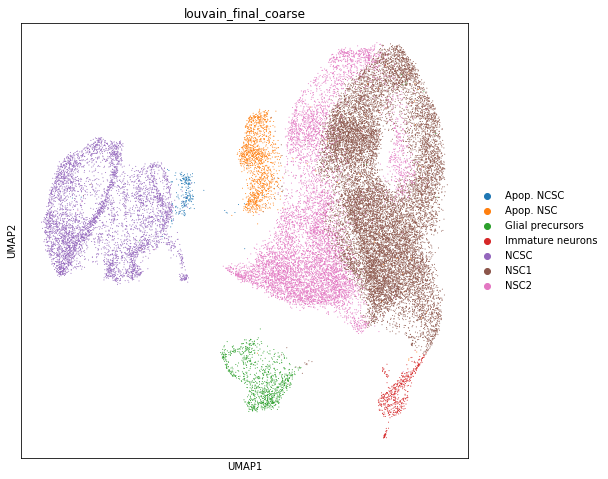

In [11]:
sc.pl.umap(adata, color='louvain_final_coarse')

# DE Testing

Calculate DE genes per cluster.

In [12]:
de_results = dict()
de_results_coarse = dict()

In [13]:
de.utils.preview_coef_names(
    sample_description=adata.obs,
    formula="~1+condition+Donor", 
)

array(['Intercept', 'condition[T.Parkinson]', 'Donor[T.UKERi1JF-R1-018]',
       'Donor[T.UKERi82A-R1-002]', 'Donor[T.UKERi88H-R1-002]',
       'Donor[T.UKERiAY6-R1-003]', 'Donor[T.UKERiC99-R1-007]',
       'Donor[T.UKERiG3G-R1-039]', 'Donor[T.UKERiJ2C-R1-015]',
       'Donor[T.UKERiM89-R1-005]', 'Donor[T.UKERiO3H-R1-005]',
       'Donor[T.UKERiPX7-R1-001]', 'Donor[T.UKERiR66-R1-007]'],
      dtype='<U24')

In [14]:
# Test the new "coarse" clusters quickly
for clust in ['NSC1', 'NSC2']:
    adata_tmp = adata[adata.obs['louvain_final_coarse'] == clust,:].copy()

    print(f'In cluster {clust}:')
    print(adata_tmp.obs.condition.value_counts())

    # Filter out genes to reduce multiple testing burden
    sc.pp.filter_genes(adata_tmp, min_cells=50)
    print(f'Testing {adata_tmp.n_vars} genes...')
    print("")
    
    test_tmp = de.test.wald(
    data=adata_tmp.layers['counts'],
    formula_loc="~ 1 + condition + Donor + size_factors",
    as_numeric=['size_factors'],
    coef_to_test=["condition[T.Parkinson]"],
    sample_description=adata_tmp.obs,
    gene_names=adata_tmp.var_names,
    constraints_loc={'Donor':'condition'},
    noise_model='nb',
    dtype="float64"
    )
    
    #Store the results
    de_results_coarse[clust] = test_tmp

In cluster NSC1:
Parkinson    9187
Control      5705
Name: condition, dtype: int64
filtered out 954 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1E4-R1-003]+Donor[UKERi1JF-R1-018]+Donor[UKERi82A-R1-002]+Donor[UKERiG3G-R1-039]+Donor[UKERiO3H-R1-005]=0, Donor[UKERi88H-R1-002]+Donor[UKERiAY6-R1-003]+Donor[UKERiC99-R1-007]+Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiPX7-R1-001]+Donor[UKERiR66-R1-007]=0


Testing 23966 genes...


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:diffxpy:Fitting model...
In cluster NSC2:
Parkinson    5147
Control      2423
Name: condition, dtype: int64
filtered out 1237 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1E4-R1-003]+Donor[UKERi1JF-R1-018]+Donor[UKERi82A-R1-002]+Donor[UKERiG3G-R1-039]+Donor[UKERiO3H-R1-005]=0, Donor[UKERi88H-R1-002]+Donor[UKERiAY6-R1-003]+Donor[UKERiC99-R1-007]+Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiPX7-R1-001]+Donor[UKERiR66-R1-007]=0


Testing 23683 genes...

INFO:diffxpy:Fitting model...


In [15]:
for clust in adata.obs['louvain_final'].cat.categories:
    adata_tmp = adata[adata.obs['louvain_final'] == clust,:].copy()

    print(f'In cluster {clust}:')
    print(adata_tmp.obs.condition.value_counts())

    # Filter out genes to reduce multiple testing burden
    sc.pp.filter_genes(adata_tmp, min_cells=50)
    print(f'Testing {adata_tmp.n_vars} genes...')
    print("")
    
    test_tmp = de.test.wald(
    data=adata_tmp.layers['counts'],
    formula_loc="~ 1 + condition + Donor + size_factors",
    as_numeric=['size_factors'],
    coef_to_test=["condition[T.Parkinson]"],
    sample_description=adata_tmp.obs,
    gene_names=adata_tmp.var_names,
    constraints_loc={'Donor':'condition'},
    noise_model='nb',
    dtype="float64"
    )
    
    #Store the results
    de_results[clust] = test_tmp
    

In cluster Glial precursors:
Parkinson    838
Control      153
Name: condition, dtype: int64
filtered out 3414 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1E4-R1-003]+Donor[UKERiG3G-R1-039]+Donor[UKERiO3H-R1-005]=0, Donor[UKERi88H-R1-002]+Donor[UKERiAY6-R1-003]+Donor[UKERiC99-R1-007]+Donor[UKERiJ2C-R1-015]+Donor[UKERiPX7-R1-001]+Donor[UKERiR66-R1-007]=0


Testing 21506 genes...

INFO:diffxpy:Fitting model...
In cluster Immature neurons:
Parkinson    399
Control      105
Name: condition, dtype: int64
filtered out 3748 genes that are detectedin less than 50 cells
Testing 21172 genes...



Built constraints: Donor[UKERi1E4-R1-003]+Donor[UKERi1JF-R1-018]+Donor[UKERi82A-R1-002]+Donor[UKERiG3G-R1-039]+Donor[UKERiO3H-R1-005]=0, Donor[UKERi88H-R1-002]+Donor[UKERiAY6-R1-003]+Donor[UKERiC99-R1-007]+Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiPX7-R1-001]+Donor[UKERiR66-R1-007]=0


INFO:diffxpy:Fitting model...
In cluster NCSC:
Control      2753
Parkinson    2251
Name: condition, dtype: int64
filtered out 1838 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1E4-R1-003]+Donor[UKERi1JF-R1-018]+Donor[UKERi82A-R1-002]+Donor[UKERiG3G-R1-039]+Donor[UKERiO3H-R1-005]=0, Donor[UKERi88H-R1-002]+Donor[UKERiAY6-R1-003]+Donor[UKERiC99-R1-007]+Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiPX7-R1-001]+Donor[UKERiR66-R1-007]=0


Testing 23082 genes...

INFO:diffxpy:Fitting model...
In cluster NSC1a:
Parkinson    4848
Control      3845
Name: condition, dtype: int64
filtered out 1256 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1E4-R1-003]+Donor[UKERi1JF-R1-018]+Donor[UKERi82A-R1-002]+Donor[UKERiG3G-R1-039]+Donor[UKERiO3H-R1-005]=0, Donor[UKERi88H-R1-002]+Donor[UKERiAY6-R1-003]+Donor[UKERiC99-R1-007]+Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiPX7-R1-001]+Donor[UKERiR66-R1-007]=0


Testing 23664 genes...

INFO:diffxpy:Fitting model...
In cluster NSC1b:
Parkinson    4339
Control      1860
Name: condition, dtype: int64
filtered out 1260 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1E4-R1-003]+Donor[UKERi1JF-R1-018]+Donor[UKERi82A-R1-002]+Donor[UKERiG3G-R1-039]+Donor[UKERiO3H-R1-005]=0, Donor[UKERi88H-R1-002]+Donor[UKERiAY6-R1-003]+Donor[UKERiC99-R1-007]+Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiPX7-R1-001]+Donor[UKERiR66-R1-007]=0


Testing 23660 genes...

INFO:diffxpy:Fitting model...
In cluster NSC2a:
Parkinson    3676
Control      1971
Name: condition, dtype: int64
filtered out 1369 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1E4-R1-003]+Donor[UKERi1JF-R1-018]+Donor[UKERi82A-R1-002]+Donor[UKERiG3G-R1-039]+Donor[UKERiO3H-R1-005]=0, Donor[UKERi88H-R1-002]+Donor[UKERiAY6-R1-003]+Donor[UKERiC99-R1-007]+Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiPX7-R1-001]+Donor[UKERiR66-R1-007]=0


Testing 23551 genes...

INFO:diffxpy:Fitting model...
In cluster NSC2b:
Parkinson    1471
Control       452
Name: condition, dtype: int64
filtered out 1619 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1E4-R1-003]+Donor[UKERi1JF-R1-018]+Donor[UKERi82A-R1-002]+Donor[UKERiG3G-R1-039]+Donor[UKERiO3H-R1-005]=0, Donor[UKERi88H-R1-002]+Donor[UKERiAY6-R1-003]+Donor[UKERiC99-R1-007]+Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiPX7-R1-001]+Donor[UKERiR66-R1-007]=0


Testing 23301 genes...

INFO:diffxpy:Fitting model...
In cluster Apop. NCSC:
Control      110
Parkinson    101
Name: condition, dtype: int64
filtered out 6096 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1E4-R1-003]+Donor[UKERi82A-R1-002]+Donor[UKERiO3H-R1-005]=0, Donor[UKERi88H-R1-002]+Donor[UKERiAY6-R1-003]+Donor[UKERiC99-R1-007]+Donor[UKERiJ2C-R1-015]+Donor[UKERiPX7-R1-001]+Donor[UKERiR66-R1-007]=0


Testing 18824 genes...

INFO:diffxpy:Fitting model...
In cluster Apop. NSC:
Parkinson    964
Control      421
Name: condition, dtype: int64
filtered out 2919 genes that are detectedin less than 50 cells


Built constraints: Donor[UKERi1E4-R1-003]+Donor[UKERi1JF-R1-018]+Donor[UKERi82A-R1-002]+Donor[UKERiG3G-R1-039]+Donor[UKERiO3H-R1-005]=0, Donor[UKERi88H-R1-002]+Donor[UKERiAY6-R1-003]+Donor[UKERiC99-R1-007]+Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiPX7-R1-001]+Donor[UKERiR66-R1-007]=0


Testing 22001 genes...

INFO:diffxpy:Fitting model...


### Bulk-like DE testing across all clusters

In [16]:
# Make a copy for the testing
adata_test = adata.copy()

print(adata_test.obs.condition.value_counts())

# Filter out genes to reduce multiple testing burden
#sc.pp.filter_genes(adata_test, min_cells=50)
print(f'Testing {adata_test.n_vars} genes...')
print("")
    
test_bulk = de.test.wald(
    data=adata_test.layers['counts'],
    formula_loc="~ 1 + condition + Donor + size_factors",
    as_numeric=['size_factors'],
    coef_to_test=["condition[T.Parkinson]"],
    sample_description=adata_test.obs,
    gene_names=adata_test.var_names,
    constraints_loc={'Donor':'condition'},
    noise_model='nb',
    dtype="float64"
)


Built constraints: Donor[UKERi1E4-R1-003]+Donor[UKERi1JF-R1-018]+Donor[UKERi82A-R1-002]+Donor[UKERiG3G-R1-039]+Donor[UKERiO3H-R1-005]=0, Donor[UKERi88H-R1-002]+Donor[UKERiAY6-R1-003]+Donor[UKERiC99-R1-007]+Donor[UKERiJ2C-R1-015]+Donor[UKERiM89-R1-005]+Donor[UKERiPX7-R1-001]+Donor[UKERiR66-R1-007]=0


Parkinson    18887
Control      11670
Name: condition, dtype: int64
Testing 24920 genes...

INFO:diffxpy:Fitting model...


# Check some data

In [17]:
de_results['NCSC'].summary().sort_values(by='qval', ascending=True).iloc[:10,:]

gene  pval  qval    log2fc      mean  zero_mean      grad  \
6046      EEF1A1P13   0.0   0.0  3.526122  0.017186      False  0.000008   
5750         RAB33B   0.0   0.0  1.392194  0.071543      False  0.000402   
13264       PSME2P6   0.0   0.0  4.722742  0.019584      False  0.000002   
14983        MYBPC1   0.0   0.0  1.034184  0.053557      False  0.009672   
5757       SCOC-AS1   0.0   0.0  2.937856  0.024181      False  0.000017   
10902  ZHX1-C8orf76   0.0   0.0 -5.390929  0.020783      False  0.007518   
5771        RPSAP36   0.0   0.0  3.389850  0.017386      False  0.000010   
5790        SLC10A7   0.0   0.0  2.475186  0.034972      False  0.000169   
1634     AL451074.4   0.0   0.0  2.608688  0.017986      False  0.000007   
14975        DEPDC4   0.0   0.0  2.098971  0.054157      False  0.000077   

       coef_mle        coef_sd           ll  
6046   3.526122   1.987313e-01  -429.236089  
5750   1.392194   1.618337e-01 -1275.239854  
13264  4.722742   1.619340e-01  -469.258262  
14983  1.034184  2.222759e-162  -583.244081  
5757   2.937856   1.922363e-01  -561.689225  
10902 -5.390929  2.222759e-162  -499.489941  
5771   3.389850   1.969828e-01  -437.171394  
5790   2.475186   1.207653e-01  -739.281808  
1634   2.608688   1.858447e-01  -442.975918  
14975  2.098971   1.047956e-01 -1041.606639

In [18]:
# Test if model did not converger for some genes and some clusters
np.sum(de_results['NCSC'].summary()['ll'] == np.float64('-inf'))
np.sum(de_results['NSC2b'].summary()['ll'] == np.float64('-inf'))

0

0

In [19]:
test_bulk.summary().sort_values(by='qval', ascending=True).iloc[:10,:]

gene  pval  qval    log2fc       mean  zero_mean      grad  \
24919  AC240274.1   0.0   0.0 -0.215353   0.232385      False  0.007500   
11230       SARAF   0.0   0.0 -0.084509   2.650816      False  0.070817   
2302        NTPCR   0.0   0.0 -0.153141   1.221848      False  0.020011   
18296      RPS27L   0.0   0.0 -0.189125  10.201099      False  0.158468   
18293        TPM1   0.0   0.0 -0.351383   3.513041      False  0.270183   
11240       RBPMS   0.0   0.0 -0.233001   0.422522      False  0.011486   
18281        RORA   0.0   0.0 -0.360363   0.111104      False  0.029110   
18279        ICE2   0.0   0.0 -0.226582   0.428772      False  0.005878   
11241      GTF2E2   0.0   0.0 -0.159598   0.471676      False  0.005869   
18277       ANXA2   0.0   0.0 -0.352547   3.599143      False  0.257500   

       coef_mle   coef_sd            ll  
24919 -0.215353  0.024086 -17223.689744  
11230 -0.084509  0.008257 -59063.199959  
2302  -0.153141  0.010827 -42776.809131  
18296 -0.189125  0.008511 -96937.161693  
18293 -0.351383  0.013908 -68595.193445  
11240 -0.233001  0.017735 -24832.097680  
18281 -0.360363  0.036635 -10492.146664  
18279 -0.226582  0.016763 -25242.927291  
11241 -0.159598  0.015909 -26487.826529  
18277 -0.352547  0.025331 -66008.532775

# Post-process data

In [29]:
de_signif_coarse = dict()
de_full_res_coarse = dict()

for clust in de_results_coarse:
    tmp = de_results_coarse[clust].summary()
    
    n_infll = np.sum(tmp['ll'] == np.float64('-inf'))
    print(f'There are {n_infll} -inf log likelihood values. Filtering these out now...')
    tmp = tmp.loc[tmp['ll'] != np.float64('-inf')]

    n_unconverged = np.sum(tmp['coef_sd'] < 10E-100)
    print(f'There are {n_unconverged} logFC std. dev.s < 10E-100. Filtering these out now...')    
    tmp = tmp.loc[tmp['coef_sd'] > 10E-100]
    
    #Sort values by q-value
    tmp.sort_values(by='qval', ascending=True, inplace=True)
    
    de_full_res_coarse[clust] = tmp.copy()
    
    #Filter by q-value to get significant DE genes
    tmp_filt = tmp.loc[tmp['qval'] < 0.05]
    de_signif_coarse[clust] = tmp_filt.copy()

There are 0 -inf log likelihood values. Filtering these out now...
There are 18 logFC std. dev.s < 10E-100. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...
There are 19 logFC std. dev.s < 10E-100. Filtering these out now...


In [30]:
de_signif = dict()
de_full_res = dict()

for clust in de_results:
    tmp = de_results[clust].summary()

    n_infll = np.sum(tmp['ll'] == np.float64('-inf'))
    print(f'There are {n_infll} -inf log likelihood values. Filtering these out now...')
    tmp = tmp.loc[tmp['ll'] != np.float64('-inf')]

    n_unconverged = np.sum(tmp['coef_sd'] < 10E-100)
    print(f'There are {n_unconverged} logFC std. dev.s < 10E-100. Filtering these out now...')    
    tmp = tmp.loc[tmp['coef_sd'] > 10E-100]
    
    #Sort values by q-value
    tmp.sort_values(by='qval', ascending=True, inplace=True)
    
    de_full_res[clust] = tmp.copy()
    
    #Filter by q-value to get significant DE genes
    tmp_filt = tmp.loc[tmp['qval'] < 0.05]
    de_signif[clust] = tmp_filt.copy()

There are 0 -inf log likelihood values. Filtering these out now...
There are 129 logFC std. dev.s < 10E-100. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...
There are 10 logFC std. dev.s < 10E-100. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...
There are 52 logFC std. dev.s < 10E-100. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...
There are 18 logFC std. dev.s < 10E-100. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...
There are 29 logFC std. dev.s < 10E-100. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...
There are 19 logFC std. dev.s < 10E-100. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these out now...
There are 5 logFC std. dev.s < 10E-100. Filtering these out now...
There are 0 -inf log likelihood values. Filtering these

In [28]:
# bulk-like data
bulk_res = test_bulk.summary()

n_infll = np.sum(bulk_res['ll'] == np.float64('-inf'))
print(f'There are {n_infll} -inf log likelihood values. Filtering these out now...')
bulk_res = bulk_res.loc[bulk_res['ll'] != np.float64('-inf')]

n_unconverged = np.sum(bulk_res['coef_sd'] < 10E-100)
print(f'There are {n_unconverged} logFC std. dev.s < 10E-100. Filtering these out now...')    
bulk_res = bulk_res.loc[bulk_res['coef_sd'] > 10E-100]

#Sort values by q-value
bulk_res.sort_values(by='qval', ascending=True, inplace=True)
        
#Filter by q-value to get significant DE genes
bulk_res_filt = bulk_res.loc[bulk_res['qval'] < 0.05]


There are 0 -inf log likelihood values. Filtering these out now...
There are 67 logFC std. dev.s < 10E-100. Filtering these out now...


# DEG analysis

In [31]:
# Number of differentially expressed genes (DEGs)
print('DEGs at FDR < 0.05:')
{clust:de_signif_coarse[clust].shape[0] for clust in de_signif_coarse}

print('DEGs at FDR < 0.01:')
{clust:de_signif_coarse[clust].loc[(de_signif_coarse[clust]['qval']<0.01)].shape[0] for clust in de_signif_coarse}

DEGs at FDR < 0.05:


{'NSC1': 6971, 'NSC2': 5517}

DEGs at FDR < 0.01:


{'NSC1': 5317, 'NSC2': 4069}

In [32]:
# Number of differentially expressed genes (DEGs)
print('DEGs at FDR < 0.05:')
{clust:de_signif[clust].shape[0] for clust in de_signif}

print('DEGs at FDR < 0.01:')
{clust:de_signif[clust].loc[(de_signif[clust]['qval']<0.01)].shape[0] for clust in de_signif}

DEGs at FDR < 0.05:


{'Glial precursors': 4417,
 'Immature neurons': 599,
 'NCSC': 3917,
 'NSC1a': 4467,
 'NSC1b': 4997,
 'NSC2a': 4348,
 'NSC2b': 2275,
 'Apop. NCSC': 619,
 'Apop. NSC': 593}

DEGs at FDR < 0.01:


{'Glial precursors': 3968,
 'Immature neurons': 500,
 'NCSC': 3337,
 'NSC1a': 3167,
 'NSC1b': 3620,
 'NSC2a': 3046,
 'NSC2b': 1546,
 'Apop. NCSC': 546,
 'Apop. NSC': 481}

In [33]:
#DEGs in bulk-like data
print('DEGs at FDR < 0.05:')
print(f'Bulk: {bulk_res_filt.shape[0]}')

print('DEGs at FDR < 0.01:')
degnum001 = bulk_res_filt.loc[(bulk_res_filt['qval']<0.01)].shape[0]
print(f'Bulk: {degnum001}')

DEGs at FDR < 0.05:
Bulk: 11288
DEGs at FDR < 0.01:
Bulk: 9433


Notes:
- there are quite a lot of DEGs at FDR < 0.05 and at FDR < 0.01
- Could use either threshold, FDR < 0.01 would be okay for higher confidence

Cluster NSC1:


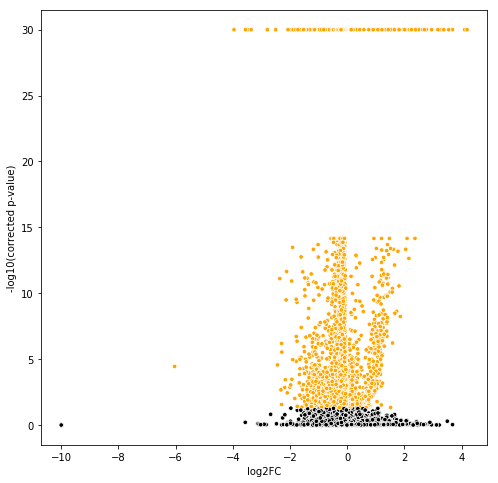

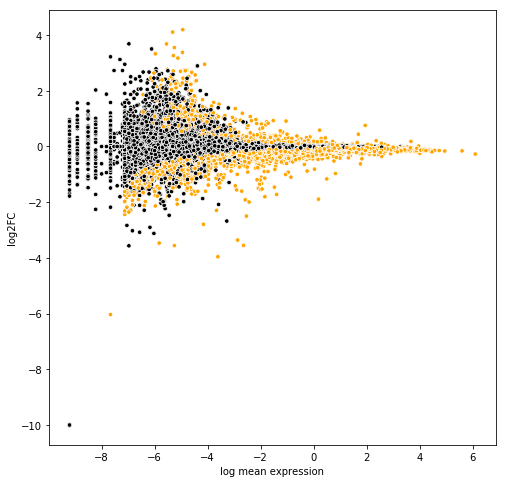

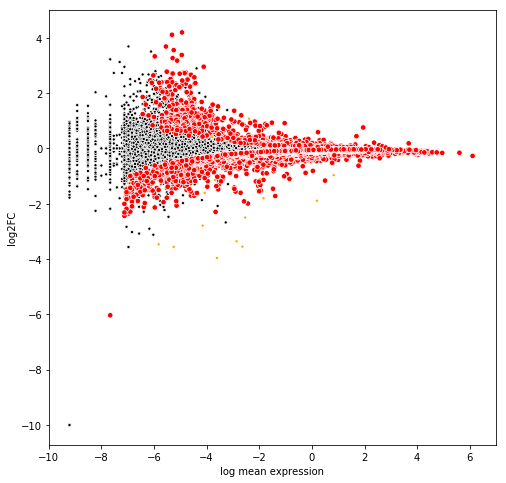

Cluster NSC2:


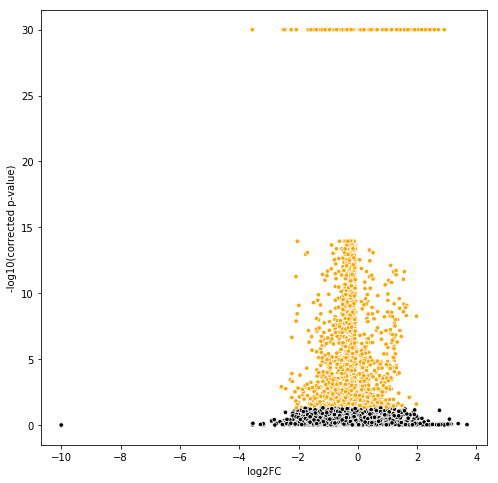

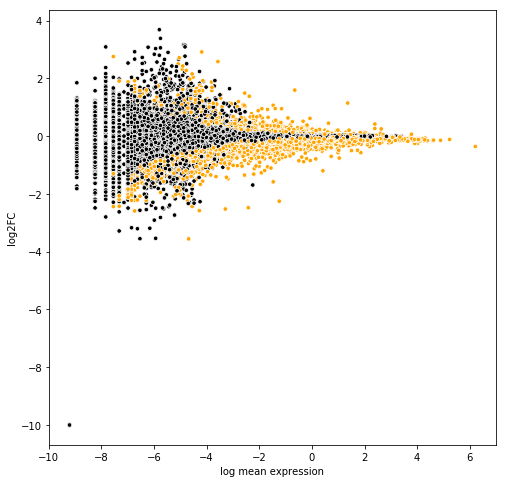

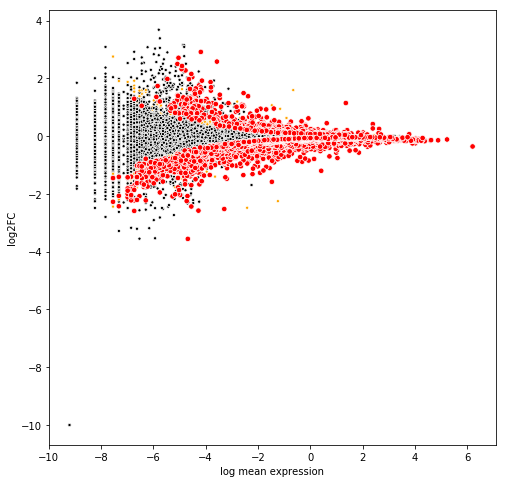

In [34]:
for clust in de_results_coarse:
    print(f'Cluster {clust}:')
    de_results_coarse[clust].plot_volcano()
    de_results_coarse[clust].plot_ma()
    de_results_coarse[clust].plot_ma(size=10, highlight_ids = np.asarray(de_full_res_coarse[clust]['gene'][de_full_res_coarse[clust]['qval'] < 0.05]))


Cluster Glial precursors:


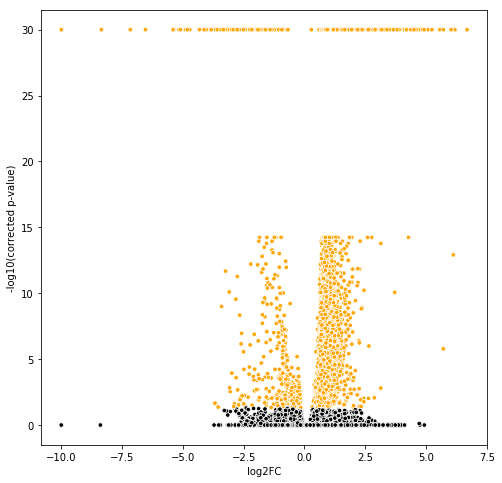

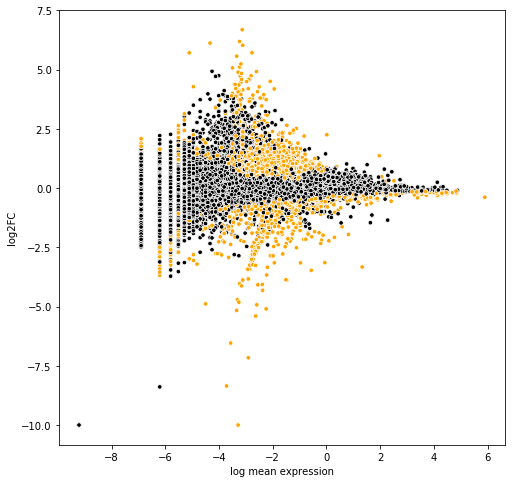

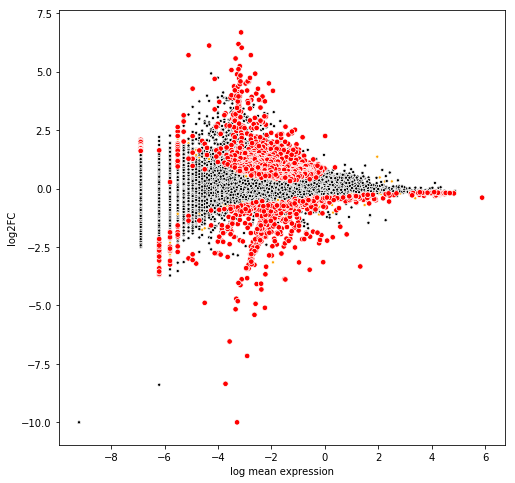

Cluster Immature neurons:


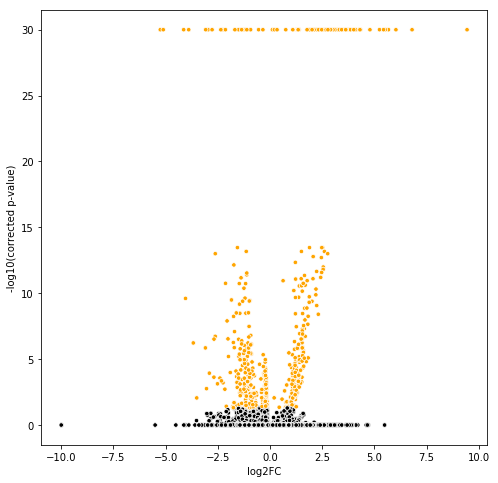

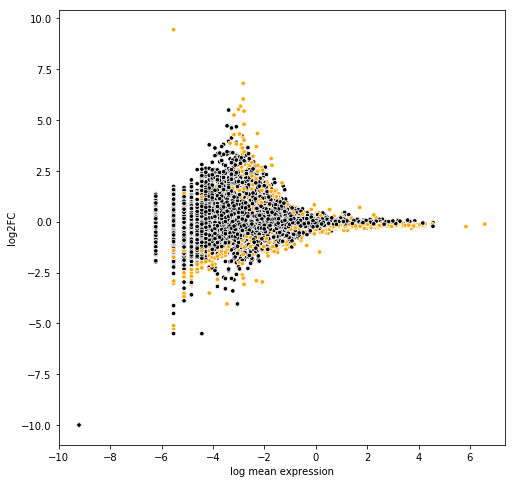

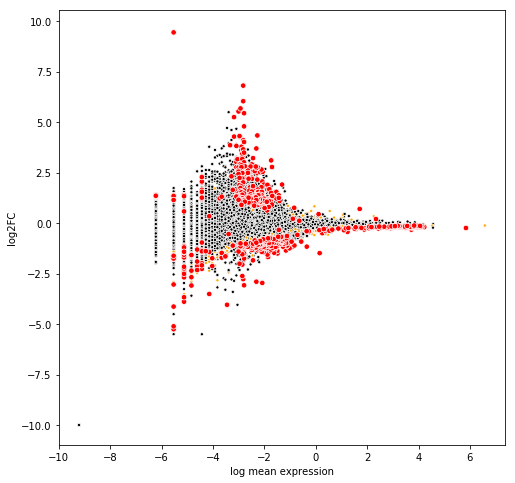

Cluster NCSC:


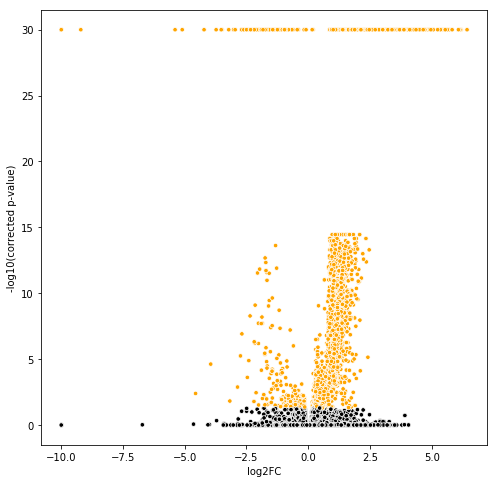

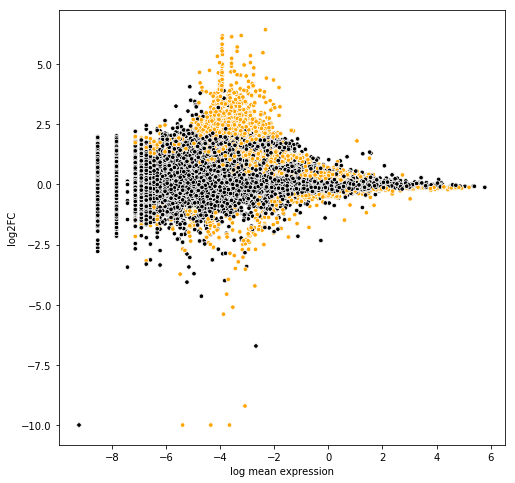

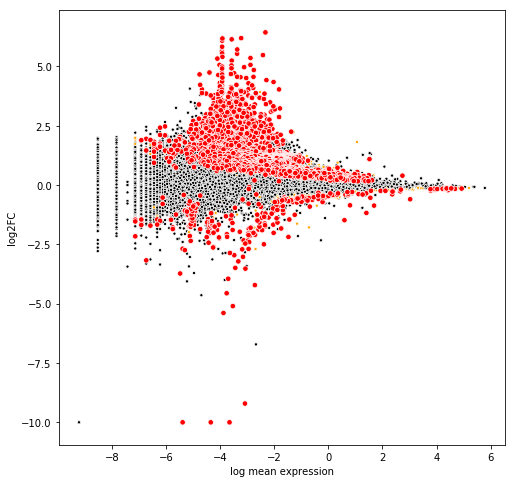

Cluster NSC1a:


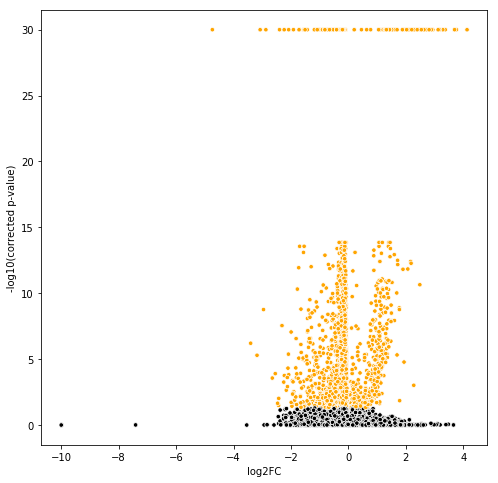

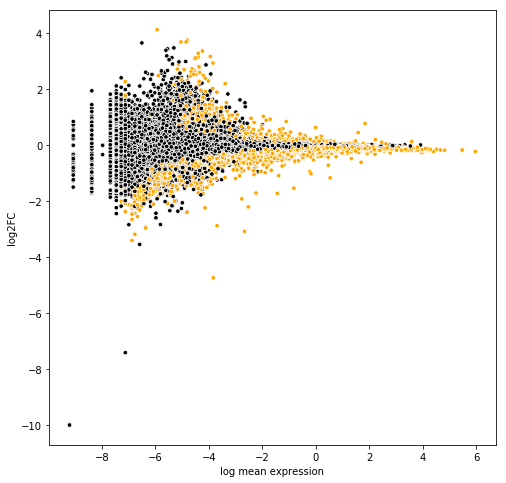

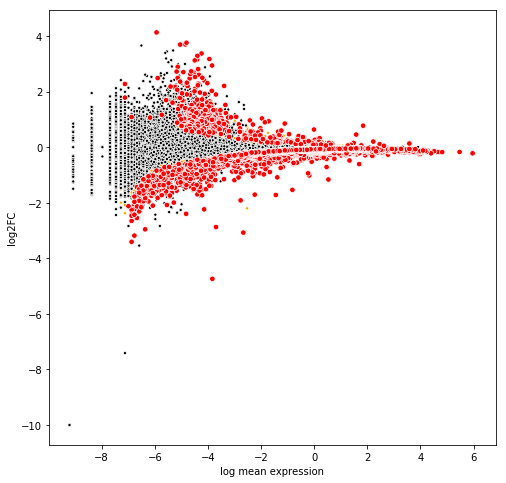

Cluster NSC1b:


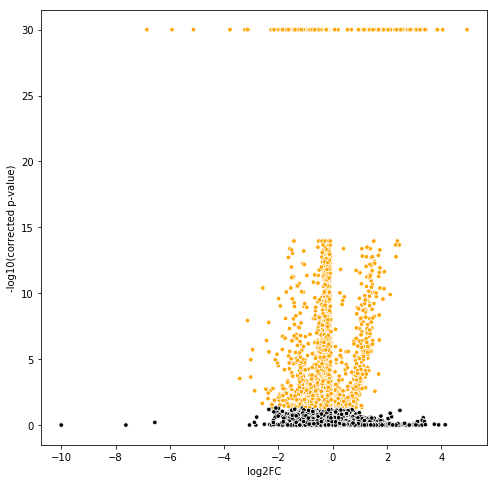

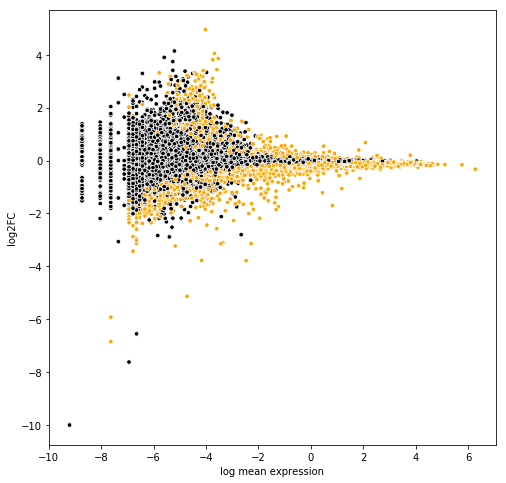

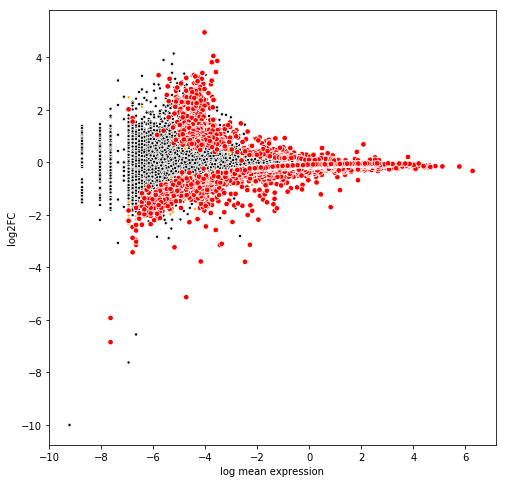

Cluster NSC2a:


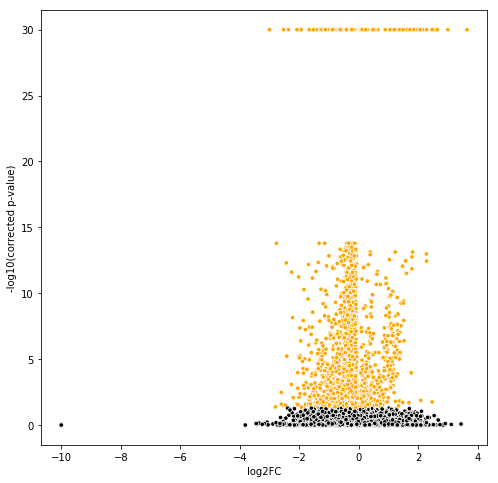

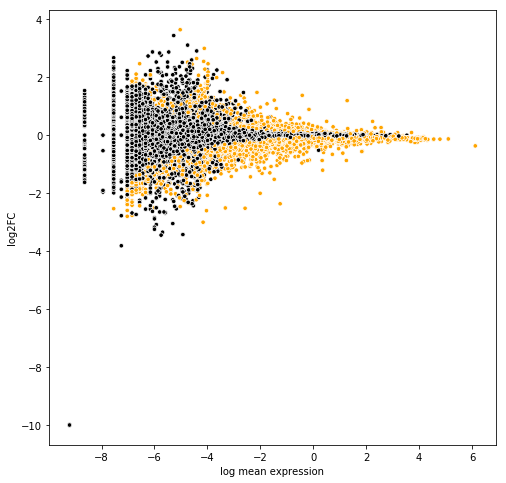

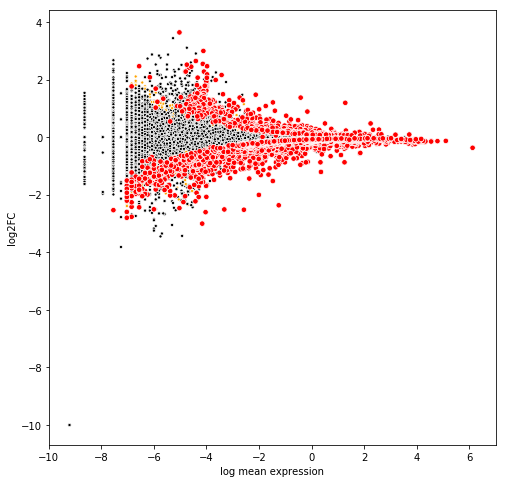

Cluster NSC2b:


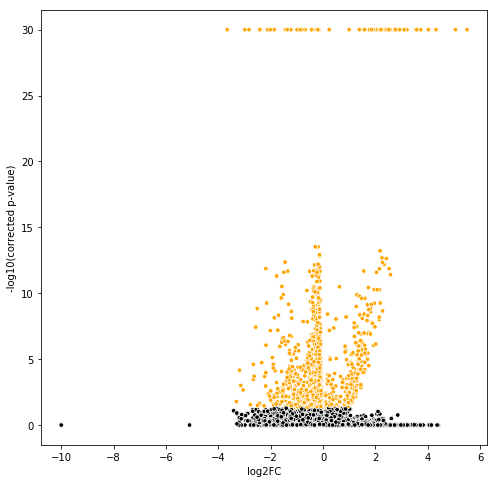

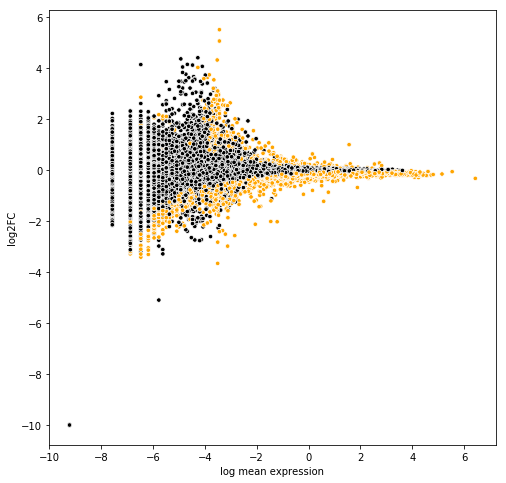

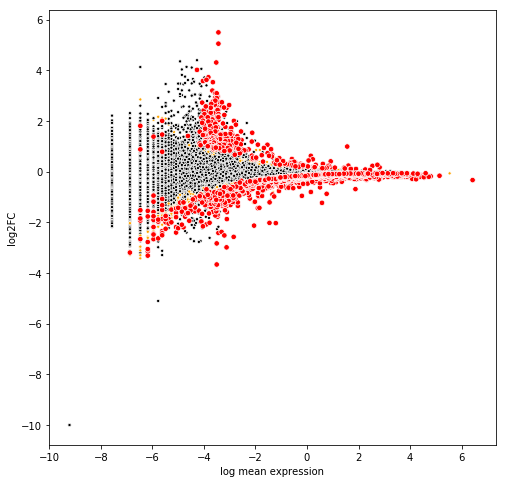

Cluster Apop. NCSC:


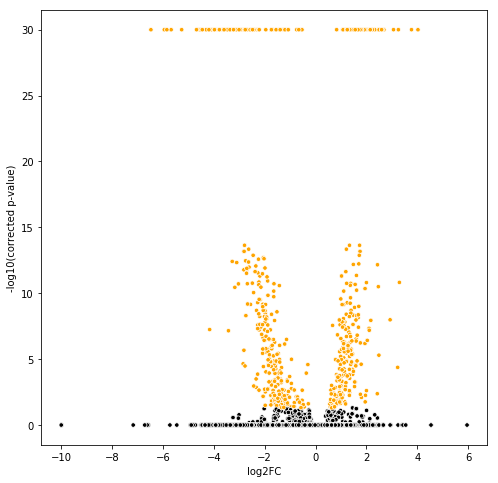

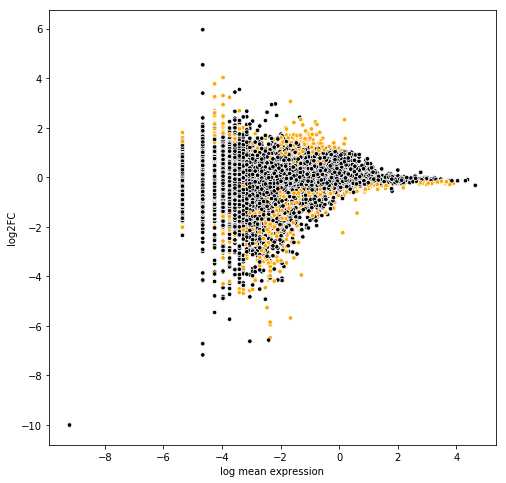

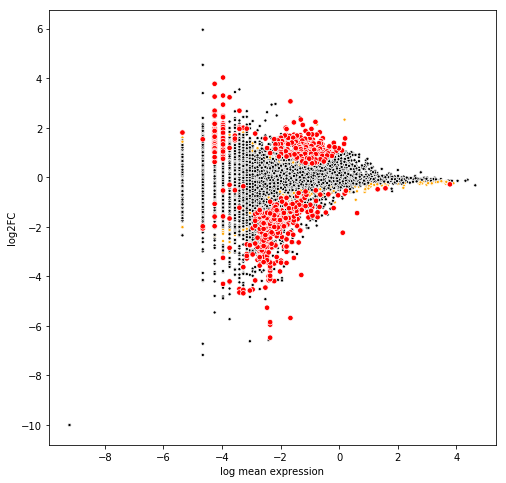

Cluster Apop. NSC:


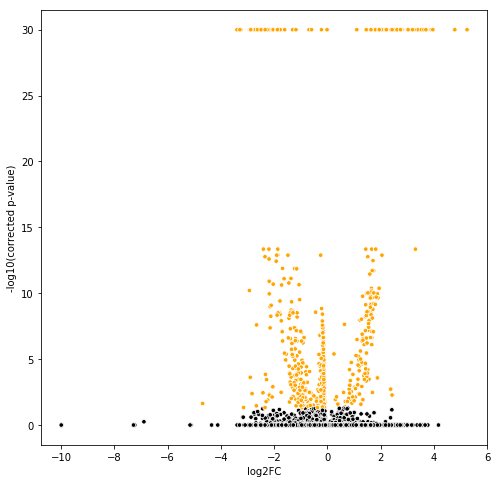

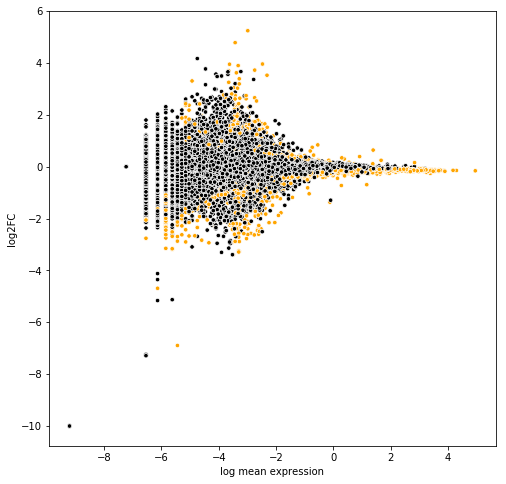

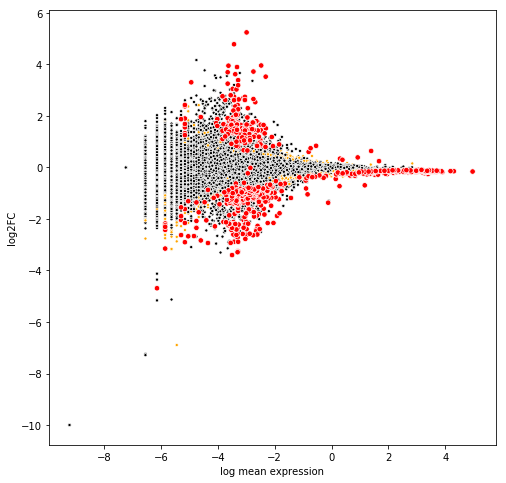

In [27]:
for clust in de_results:
    print(f'Cluster {clust}:')
    de_results[clust].plot_volcano()
    de_results[clust].plot_ma()
    de_results[clust].plot_ma(size=10, highlight_ids = np.asarray(de_full_res[clust]['gene'][de_full_res[clust]['qval'] < 0.05]))


Bulk-like:


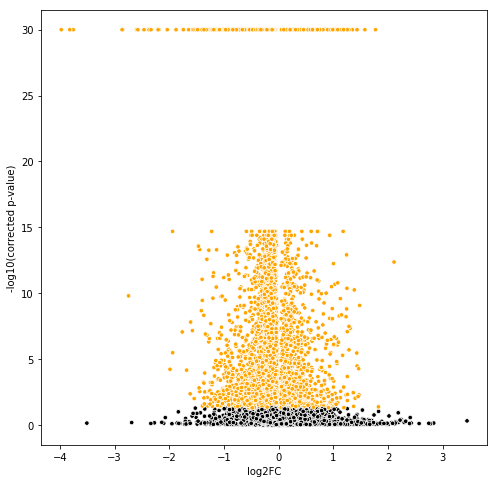

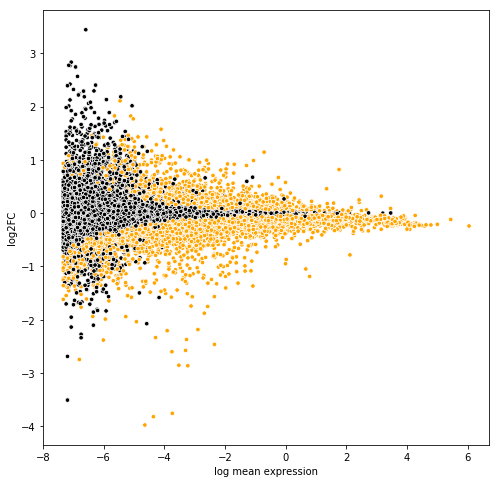

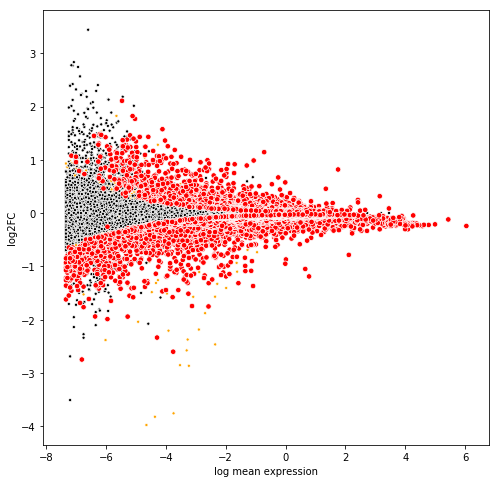

In [35]:
print('Bulk-like:')
test_bulk.plot_volcano()
test_bulk.plot_ma()
test_bulk.plot_ma(size=10, highlight_ids = np.asarray(bulk_res['gene'][bulk_res['qval'] < 0.05]))

## Enrichment analysis

In [36]:
# Plotting functions - 'GProfiler-official version'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import colors
from matplotlib import rcParams


def scale_data_5_75(data):
    mind = np.min(data)
    maxd = np.max(data)
    
    if maxd == mind:
        maxd=maxd+1
        mind=mind-1
        
    drange = maxd - mind
    return ((((data - mind)/drange*0.70)+0.05)*100)


def plot_enrich(data, n_terms=20, save=False):
    # Test data input
    if not isinstance(data, pd.DataFrame):
        raise ValueError('Please input a Pandas Dataframe output by gprofiler.')
        
    if not np.all([term in data.columns for term in ['p_value', 'name', 'intersection_size']]):
        raise TypeError('The data frame {} does not contain enrichment results from gprofiler.'.format(data))
    
    data_to_plot = data.iloc[:n_terms,:].copy()
    data_to_plot['go.id'] = data_to_plot.index

    min_pval = data_to_plot['p_value'].min()
    max_pval = data_to_plot['p_value'].max()
    
    # Scale intersection_size to be between 5 and 75 for plotting
    #Note: this is done as calibration was done for values between 5 and 75
    data_to_plot['scaled.overlap'] = scale_data_5_75(data_to_plot['intersection_size'])
    
    norm = colors.LogNorm(min_pval, max_pval)
    sm = plt.cm.ScalarMappable(cmap="cool", norm=norm)
    sm.set_array([])

    rcParams.update({'font.size': 14, 'font.weight': 'bold'})

    sb.set(style="whitegrid")

    path = plt.scatter(x='recall', y="name", c='p_value', cmap='cool', 
                       norm=colors.LogNorm(min_pval, max_pval), 
                       data=data_to_plot, linewidth=1, edgecolor="grey", 
                       s=[(i+10)**1.5 for i in data_to_plot['scaled.overlap']])
    ax = plt.gca()
    ax.invert_yaxis()

    ax.set_ylabel('')
    ax.set_xlabel('Gene ratio', fontsize=14, fontweight='bold')
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Get tick marks for this plot
    #Note: 6 ticks maximum
    min_tick = np.floor(np.log10(min_pval)).astype(int)
    max_tick = np.ceil(np.log10(max_pval)).astype(int)
    tick_step = np.ceil((max_tick - min_tick)/6).astype(int)
    
    # Ensure no 0 values
    if tick_step == 0:
        tick_step = 1
        min_tick = max_tick-1
    
    ticks_vals = [10**i for i in range(max_tick, min_tick-1, -tick_step)]
    ticks_labs = ['$10^{'+str(i)+'}$' for i in range(max_tick, min_tick-1, -tick_step)]

    #Colorbar
    fig = plt.gcf()
    cbaxes = fig.add_axes([0.8, 0.15, 0.03, 0.4])
    cbar = ax.figure.colorbar(sm, ticks=ticks_vals, shrink=0.5, anchor=(0,0.1), cax=cbaxes)
    cbar.ax.set_yticklabels(ticks_labs)
    cbar.set_label("Adjusted p-value", fontsize=14, fontweight='bold')

    #Size legend
    min_olap = data_to_plot['intersection_size'].min()
    max_olap = data_to_plot['intersection_size'].max()
    olap_range = max_olap - min_olap
    
    #Note: approximate scaled 5, 25, 50, 75 values are calculated
    #      and then rounded to nearest number divisible by 5
    size_leg_vals = [np.round(i/5)*5 for i in 
                          [min_olap, min_olap+(20/70)*olap_range, min_olap+(45/70)*olap_range, max_olap]]
    size_leg_scaled_vals = scale_data_5_75(size_leg_vals)

    
    l1 = plt.scatter([],[], s=(size_leg_scaled_vals[0]+10)**1.5, edgecolors='none', color='black')
    l2 = plt.scatter([],[], s=(size_leg_scaled_vals[1]+10)**1.5, edgecolors='none', color='black')
    l3 = plt.scatter([],[], s=(size_leg_scaled_vals[2]+10)**1.5, edgecolors='none', color='black')
    l4 = plt.scatter([],[], s=(size_leg_scaled_vals[3]+10)**1.5, edgecolors='none', color='black')

    labels = [str(int(i)) for i in size_leg_vals]

    leg = plt.legend([l1, l2, l3, l4], labels, ncol=1, frameon=False, fontsize=12,
                     handlelength=1, loc = 'center left', borderpad = 1, labelspacing = 1.4,
                     handletextpad=2, title='Gene overlap', scatterpoints = 1,  bbox_to_anchor=(-2, 1.5), 
                     facecolor='black')

    if save:
        plt.savefig(save, dpi=300, format='pdf')

    plt.show()

### Biological Process GO Term enrichment

Background genes for DE testing was changed from genes actually tested to annotated genes. Often there are fewer annotated genes than ones we are testing over. We should actually use the annotated and tested genes as background, but this is currently not possible in gprofiler-official.

In [37]:
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')

In [38]:
de_gobp_enrich_coarse = dict()

for clust in de_signif_coarse:
    tmp = gp.profile(organism='hsapiens', sources=['GO:BP'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               domain_scope='annotated', 
                               query=de_signif_coarse[clust]['gene'].tolist())
    
    if tmp is not None:
        tmp.set_index('native', inplace=True)
        de_gobp_enrich_coarse[clust] = tmp.sort_values('p_value').iloc[:,[2,5,7,10,1]]
    else:
        de_gobp_enrich_coarse[clust] = pd.DataFrame()
    
    # Print some results
    print(f'Cluster {clust}:')
    de_gobp_enrich_coarse[clust].iloc[:50,:]

Cluster NSC1:


p_value  term_size  intersection_size    recall  \
native                                                              
GO:0071840  5.241734e-110       6880               2685  0.390262   
GO:0016043  1.263058e-103       6661               2597  0.389881   
GO:0006996  2.539589e-100       4136               1775  0.429159   
GO:0044237   1.421448e-72      10941               3735  0.341376   
GO:0044260   6.857130e-62       8430               2978  0.353262   
GO:0044267   5.932613e-61       5280               2016  0.381818   
GO:0051641   7.259843e-60       3519               1441  0.409491   
GO:0046907   1.527808e-59       1723                814  0.472432   
GO:0044085   8.506178e-58       3377               1386  0.410423   
GO:0070727   7.299626e-57       1856                855  0.460668   
GO:0034613   7.299626e-57       1842                850  0.461455   
GO:0007049   3.440192e-56       1867                857  0.459025   
GO:0016032   2.296378e-55       1011                532  0.526212   
GO:0008104   1.165648e-54       2670               1135  0.425094   
GO:0022607   1.780856e-54       3104               1282  0.413015   
GO:0033365   2.111038e-54        974                515  0.528747   
GO:0006807   1.132697e-53      10148               3436  0.338589   
GO:0000278   2.703729e-52       1098                559  0.509107   
GO:0044265   3.142426e-52       1244                615  0.494373   
GO:0009057   1.371629e-50       1479                699  0.472617   
GO:1903047   1.463729e-49        956                497  0.519874   
GO:0033036   2.228282e-49       3148               1278  0.405972   
GO:0044238   5.474392e-49      10642               3554  0.333960   
GO:0019538   2.943136e-48       5912               2158  0.365020   
GO:0051649   3.390195e-48       2778               1149  0.413607   
GO:0045184   3.846929e-45       1866                823  0.441050   
GO:0022402   1.054953e-44       1388                649  0.467579   
GO:0008152   5.553611e-44      11915               3884  0.325976   
GO:0016071   6.422133e-44        880                454  0.515909   
GO:0051128   2.619562e-43       2439               1016  0.416564   
GO:0015031   3.151951e-43       1754                777  0.442987   
GO:1901564   1.114827e-42       6904               2434  0.352549   
GO:0034641   3.894948e-42       6576               2332  0.354623   
GO:0006886   5.235042e-42        995                494  0.496482   
GO:0043170   7.025250e-42       9867               3300  0.334448   
GO:0070972   1.998746e-41        144                122  0.847222   
GO:0043933   2.252044e-40       2017                860  0.426376   
GO:0006613   4.451702e-40        102                 95  0.931373   
GO:0006139   5.650889e-40       5752               2069  0.359701   
GO:0031323   1.239754e-39       6309               2238  0.354731   
GO:0006614   1.462726e-38         96                 90  0.937500   
GO:0072599   2.303200e-38        115                102  0.886957   
GO:0033554   2.303200e-38       2142                896  0.418301   
GO:0006464   4.386703e-38       4108               1544  0.375852   
GO:0036211   4.386703e-38       4108               1544  0.375852   
GO:0072594   8.544285e-38        523                296  0.565966   
GO:0033043   8.544285e-38       1228                570  0.464169   
GO:0045047   9.659373e-38        111                 99  0.891892   
GO:0090304   1.038083e-37       5234               1897  0.362438   
GO:0006413   1.514965e-37        203                150  0.738916   

                                                         name  
native                                                         
GO:0071840      cellular component organization or biogenesis  
GO:0016043                    cellular component organization  
GO:0006996                             organelle organization  
GO:0044237                         cellular metabolic process  
GO:0044260           cellular macromolecule m

Cluster NSC2:


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0071840  1.981624e-94       6880               2235  0.324855   
GO:0016043  3.171278e-86       6661               2153  0.323225   
GO:0006996  4.615240e-76       4136               1456  0.352031   
GO:0051641  1.094138e-48       3519               1195  0.339585   
GO:0044267  1.603317e-47       5280               1658  0.314015   
GO:0044085  1.760073e-47       3377               1151  0.340835   
GO:0046907  4.181685e-47       1723                675  0.391759   
GO:0008104  2.094578e-45       2670                946  0.354307   
GO:0006613  1.837012e-44        102                 93  0.911765   
GO:0034613  2.863383e-44       1842                702  0.381107   
GO:0070727  2.955515e-44       1856                706  0.380388   
GO:0006614  3.991880e-44         96                 89  0.927083   
GO:0033036  9.510691e-44       3148               1073  0.340851   
GO:0022607  9.669081e-43       3104               1057  0.340528   
GO:0051649  3.923874e-42       2778                964  0.347012   
GO:0051128  4.552037e-40       2439                861  0.353014   
GO:0072599  5.676446e-40        115                 97  0.843478   
GO:0000278  1.519029e-39       1098                460  0.418944   
GO:0007049  2.994284e-39       1867                693  0.371184   
GO:0045047  4.504575e-39        111                 94  0.846847   
GO:0045184  4.504575e-39       1866                692  0.370847   
GO:1903047  4.703536e-39        956                413  0.432008   
GO:0019538  9.939788e-39       5912               1778  0.300744   
GO:0044260  2.507356e-38       8430               2396  0.284223   
GO:0070972  9.111358e-38        144                110  0.763889   
GO:0015031  1.198431e-36       1754                651  0.371152   
GO:0044237  1.542981e-36      10941               2975  0.271913   
GO:0033365  2.058340e-36        974                412  0.422998   
GO:0002181  2.232200e-36        149                111  0.744966   
GO:0044265  1.864484e-35       1244                494  0.397106   
GO:0009057  5.060090e-35       1479                564  0.381339   
GO:0072657  5.744116e-35        698                318  0.455587   
GO:0000184  2.729240e-34        123                 96  0.780488   
GO:0006413  4.778904e-34        203                133  0.655172   
GO:0022402  1.495854e-33       1388                532  0.383285   
GO:0051668  1.824152e-33        775                340  0.438710   
GO:1901564  2.662025e-33       6904               1998  0.289397   
GO:0006886  7.885315e-33        995                409  0.411055   
GO:0090150  2.163520e-31        385                201  0.522078   
GO:0033554  2.590413e-29       2142                736  0.343604   
GO:0051246  2.652587e-29       2759                907  0.328742   
GO:0007010  3.783716e-29       1473                543  0.368635   
GO:0016032  6.549988e-29       1011                403  0.398615   
GO:0006807  8.216772e-29      10148               2751  0.271088   
GO:0000956  1.933836e-28        214                130  0.607477   
GO:0048523  5.828971e-28       5153               1530  0.296914   
GO:0032268  1.698369e-27       2591                853  0.329217   
GO:0071705  1.034698e-26       2216                746  0.336643   
GO:0031323  1.034698e-26       6309               1814  0.287526   
GO:0051301  2.243699e-26        630                275  0.436508   

                                                         name  
native                                                         
GO:0071840      cellular component organization or biogenesis  
GO:0016043                    cellular component organization  
GO:0006996                             organelle organization  
GO:0051641                              cellular localization  
GO:0044267                 cellular protein metabolic process  
GO:0044085                      

In [39]:
de_gobp_enrich = dict()

for clust in de_signif:
    tmp = gp.profile(organism='hsapiens', sources=['GO:BP'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               domain_scope='annotated', 
                               query=de_signif[clust]['gene'].tolist())
    
    if tmp is not None:
        tmp.set_index('native', inplace=True)
        de_gobp_enrich[clust] = tmp.sort_values('p_value').iloc[:,[2,5,7,10,1]]
    else:
        de_gobp_enrich[clust] = pd.DataFrame()
    
    # Print some results
    print(f'Cluster {clust}:')
    de_gobp_enrich[clust].iloc[:50,:]

Cluster Glial precursors:


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0044237  5.053373e-49      10941               2475  0.226213   
GO:0044238  6.565137e-40      10642               2384  0.224018   
GO:0006807  2.497033e-35      10148               2273  0.223985   
GO:0044260  6.494819e-33       8430               1938  0.229893   
GO:0008152  6.494819e-33      11915               2580  0.216534   
GO:0071704  7.679107e-31      11397               2478  0.217426   
GO:0043170  4.211938e-26       9867               2174  0.220330   
GO:0046483  1.220610e-25       5929               1409  0.237645   
GO:0006139  1.939221e-25       5752               1372  0.238526   
GO:1901360  4.165268e-24       6227               1460  0.234463   
GO:0043412  6.996675e-24       4345               1075  0.247411   
GO:0090304  2.582870e-23       5234               1255  0.239778   
GO:0034641  6.413983e-23       6576               1522  0.231448   
GO:0006725  6.413983e-23       5973               1402  0.234723   
GO:0006996  1.455811e-22       4136               1024  0.247582   
GO:0036211  1.761552e-20       4108               1007  0.245131   
GO:0006464  1.761552e-20       4108               1007  0.245131   
GO:0044248  8.960334e-20       2381                634  0.266275   
GO:0044267  1.089594e-19       5280               1243  0.235417   
GO:0009056  1.340232e-19       2779                720  0.259086   
GO:0006396  3.222653e-19       1010                316  0.312871   
GO:0034470  3.222653e-19        439                169  0.384966   
GO:0016070  8.714197e-19       4714               1122  0.238014   
GO:1901576  3.591649e-18       6297               1437  0.228204   
GO:0009058  6.243201e-18       6391               1454  0.227507   
GO:0044249  1.288799e-17       6210               1416  0.228019   
GO:0070647  5.171356e-17       1193                352  0.295054   
GO:0034660  1.632463e-16        535                188  0.351402   
GO:1901564  5.257011e-16       6904               1542  0.223349   
GO:0034645  5.420475e-16       5081               1179  0.232041   
GO:0009059  1.049570e-15       5145               1190  0.231293   
GO:0046907  1.199260e-15       1723                468  0.271619   
GO:0071840  5.288707e-15       6880               1530  0.222384   
GO:0019538  6.886086e-15       5912               1338  0.226319   
GO:0032446  8.460414e-15        980                293  0.298980   
GO:0009057  8.460414e-15       1479                409  0.276538   
GO:1901575  2.794154e-14       2289                586  0.256007   
GO:0022613  2.234726e-13        473                163  0.344609   
GO:0044265  2.366553e-13       1244                349  0.280547   
GO:0033036  3.229716e-13       3148                763  0.242376   
GO:0008104  4.640902e-13       2670                661  0.247566   
GO:0033554  1.358596e-12       2142                545  0.254435   
GO:0042254  1.634418e-12        335                124  0.370149   
GO:0016072  2.492624e-12        275                107  0.389091   
GO:0006364  2.963835e-12        265                104  0.392453   
GO:0016570  8.852289e-12        472                158  0.334746   
GO:0016569  2.935935e-11        486                160  0.329218   
GO:0070727  3.537813e-11       1856                475  0.255927   
GO:0016567  3.563084e-11        900                260  0.288889   
GO:0044085  7.640286e-11       3377                795  0.235416   

                                                         name  
native                                                         
GO:0044237                         cellular metabolic process  
GO:0044238                          primary metabolic process  
GO:0006807                nitrogen compound metabolic process  
GO:0044260           cellular macromolecule metabolic process  
GO:0008152                                  metabolic process  
GO:0071704                organi

Cluster Immature neurons:


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0006614  1.428151e-67         96                 58  0.604167   
GO:0006613  1.211803e-65        102                 58  0.568627   
GO:0045047  7.728968e-63        111                 58  0.522523   
GO:0072599  9.383844e-62        115                 58  0.504348   
GO:0000184  5.728730e-58        123                 57  0.463415   
GO:0002181  1.168430e-56        149                 60  0.402685   
GO:0019083  6.007152e-55        181                 63  0.348066   
GO:0070972  8.455254e-55        144                 58  0.402778   
GO:0019080  3.422640e-53        237                 68  0.286920   
GO:0006612  8.247811e-52        219                 65  0.296804   
GO:0006413  3.490496e-50        203                 62  0.305419   
GO:0000956  9.616108e-45        214                 59  0.275701   
GO:0090150  2.366092e-38        385                 68  0.176623   
GO:0006605  2.933210e-36        400                 67  0.167500   
GO:0072594  3.433163e-35        523                 74  0.141491   
GO:0006402  3.338302e-31        388                 61  0.157216   
GO:0006401  1.669695e-29        431                 62  0.143852   
GO:0016072  2.552195e-28        275                 50  0.181818   
GO:0006364  4.279815e-28        265                 49  0.184906   
GO:0072657  2.452274e-25        698                 72  0.103152   
GO:0006886  2.846313e-25        995                 86  0.086432   
GO:0042254  3.431687e-25        335                 51  0.152239   
GO:0051668  8.825434e-25        775                 75  0.096774   
GO:0033365  1.336454e-24        974                 84  0.086242   
GO:0034655  2.805242e-24        573                 64  0.111693   
GO:0016032  3.409058e-24       1011                 85  0.084075   
GO:0034470  6.343317e-24        439                 56  0.127563   
GO:0006412  7.476054e-24        804                 75  0.093284   
GO:0043043  7.198577e-23        834                 75  0.089928   
GO:0046700  1.467742e-22        617                 64  0.103728   
GO:0044270  2.425206e-22        623                 64  0.102729   
GO:0019439  7.320584e-22        636                 64  0.100629   
GO:1901361  1.388442e-21        664                 65  0.097892   
GO:0022613  1.430463e-21        473                 55  0.116279   
GO:0034660  2.686585e-21        535                 58  0.108411   
GO:0043604  4.192222e-20        975                 77  0.078974   
GO:0016071  6.714517e-19        880                 71  0.080682   
GO:0006518  6.907959e-19        998                 76  0.076152   
GO:0046907  1.855085e-18       1723                103  0.059779   
GO:0034645  1.131150e-16       5081                199  0.039166   
GO:0009059  2.019254e-16       5145                200  0.038873   
GO:0043603  2.118157e-16       1284                 83  0.064642   
GO:0015031  6.417110e-16       1754                 99  0.056442   
GO:0034613  6.426035e-16       1842                102  0.055375   
GO:0070727  1.066678e-15       1856                102  0.054957   
GO:0045184  4.525468e-15       1866                101  0.054126   
GO:0044265  1.406494e-14       1244                 78  0.062701   
GO:0044271  2.313357e-14       5054                192  0.037990   
GO:1901566  2.838818e-14       1889                100  0.052938   
GO:0009057  7.800285e-14       1479                 85  0.057471   

                                                         name  
native                                                         
GO:0006614  SRP-dependent cotranslational protein targetin...  
GO:0006613      cotranslational protein targeting to membrane  
GO:0045047                            protein targeting to ER  
GO:0072599  establishment of protein localization to endop...  
GO:0000184  nuclear-transcribed mRNA catabolic process, no...  
GO:0002181                      

Cluster NCSC:


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0044237  1.209436e-24      10941               1669  0.152545   
GO:0044238  3.039414e-19      10642               1605  0.150818   
GO:0006807  2.005190e-16      10148               1527  0.150473   
GO:0008152  3.094010e-16      11915               1745  0.146454   
GO:0071704  5.697673e-15      11397               1674  0.146881   
GO:0034641  2.957871e-13       6576               1038  0.157847   
GO:0046483  1.064037e-12       5929                946  0.159555   
GO:0006725  4.059267e-12       5973                948  0.158714   
GO:0006139  6.713162e-12       5752                916  0.159249   
GO:1901360  1.189728e-11       6227                979  0.157219   
GO:0044260  8.222365e-11       8430               1267  0.150297   
GO:0090304  1.078885e-10       5234                836  0.159725   
GO:0043170  2.640557e-09       9867               1442  0.146144   
GO:0016070  7.190081e-08       4714                744  0.157828   
GO:1901576  2.503469e-07       6297                956  0.151818   
GO:0006396  3.674852e-07       1010                199  0.197030   
GO:0044249  4.196839e-07       6210                942  0.151691   
GO:0009058  5.876564e-07       6391                965  0.150994   
GO:0045184  6.717443e-07       1866                329  0.176313   
GO:0015031  6.964960e-07       1754                312  0.177879   
GO:0046907  1.163685e-06       1723                306  0.177597   
GO:0070647  1.834208e-06       1193                224  0.187762   
GO:0008104  2.423776e-06       2670                443  0.165918   
GO:0032543  4.008252e-06        135                 43  0.318519   
GO:0044271  1.675292e-05       5054                770  0.152355   
GO:0140053  1.690081e-05        166                 48  0.289157   
GO:0034660  1.741740e-05        535                114  0.213084   
GO:0044248  4.590628e-05       2381                392  0.164637   
GO:0034470  5.208917e-05        439                 96  0.218679   
GO:0044782  5.631402e-05        440                 96  0.218182   
GO:0008033  5.727571e-05        133                 40  0.300752   
GO:0006399  8.626417e-05        191                 51  0.267016   
GO:0070126  9.072335e-05         88                 30  0.340909   
GO:0060271  1.140808e-04        418                 91  0.217703   
GO:0070925  1.147115e-04        921                172  0.186754   
GO:0006996  1.175752e-04       4136                635  0.153530   
GO:0009059  1.208900e-04       5145                773  0.150243   
GO:0033036  1.208900e-04       3148                497  0.157878   
GO:0006886  1.233632e-04        995                183  0.183920   
GO:0034645  1.233632e-04       5081                764  0.150364   
GO:0009451  1.393300e-04        169                 46  0.272189   
GO:0009056  1.404839e-04       2779                444  0.159770   
GO:0070125  1.855377e-04         87                 29  0.333333   
GO:0048193  2.309228e-04        415                 89  0.214458   
GO:0032446  2.323831e-04        980                179  0.182653   
GO:0034613  2.741806e-04       1842                307  0.166667   
GO:0016050  3.208135e-04        342                 76  0.222222   
GO:0006415  3.438070e-04        104                 32  0.307692   
GO:0071705  3.562444e-04       2216                360  0.162455   
GO:0070727  3.562444e-04       1856                308  0.165948   

                                                         name  
native                                                         
GO:0044237                         cellular metabolic process  
GO:0044238                          primary metabolic process  
GO:0006807                nitrogen compound metabolic process  
GO:0008152                                  metabolic process  
GO:0071704                organic substance metabolic process  
GO:0034641       cellular nitrog

Cluster NSC1a:


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0046907  1.708319e-60       1723                603  0.349971   
GO:0071840  1.130411e-57       6880               1712  0.248837   
GO:0006614  3.201372e-51         96                 88  0.916667   
GO:0006613  1.086708e-50        102                 91  0.892157   
GO:0070972  2.448529e-50        144                112  0.777778   
GO:0045047  1.368398e-49        111                 95  0.855856   
GO:0072599  1.531043e-49        115                 97  0.843478   
GO:0006413  1.123978e-48        203                136  0.669951   
GO:0051641  2.392445e-48       3519                983  0.279341   
GO:0044237  2.392445e-48      10941               2426  0.221735   
GO:0016043  2.556021e-48       6661               1631  0.244858   
GO:0051649  9.939022e-48       2778                816  0.293737   
GO:0002181  6.049852e-47        149                111  0.744966   
GO:0006996  7.953158e-47       4136               1110  0.268375   
GO:0000184  5.650654e-46        123                 98  0.796748   
GO:0008104  8.306845e-46       2670                785  0.294007   
GO:0016032  1.053216e-44       1011                379  0.374876   
GO:0015031  1.116588e-44       1754                567  0.323261   
GO:0045184  1.116588e-44       1866                594  0.318328   
GO:0033036  8.320062e-44       3148                885  0.281131   
GO:0006886  3.976440e-43        995                371  0.372864   
GO:0070727  1.959586e-42       1856                585  0.315194   
GO:0034613  3.158157e-42       1842                581  0.315418   
GO:0044085  1.804029e-40       3377                923  0.273320   
GO:0016071  1.930525e-40        880                334  0.379545   
GO:0044265  5.073621e-40       1244                428  0.344051   
GO:0000956  4.519999e-39        214                129  0.602804   
GO:0033365  2.859756e-38        974                354  0.363450   
GO:0009057  5.163556e-38       1479                481  0.325220   
GO:0071705  1.285204e-37       2216                654  0.295126   
GO:0072594  2.689418e-37        523                227  0.434034   
GO:0043933  9.068667e-36       2017                602  0.298463   
GO:0019080  1.165125e-35        237                133  0.561181   
GO:0006605  3.498005e-35        400                186  0.465000   
GO:0090150  5.348048e-35        385                181  0.470130   
GO:0006518  5.916856e-35        998                352  0.352705   
GO:0006412  1.500600e-34        804                300  0.373134   
GO:0043043  4.004110e-34        834                307  0.368106   
GO:0006402  6.948647e-34        388                180  0.463918   
GO:0006401  8.441582e-34        431                193  0.447796   
GO:0019083  9.532147e-34        181                110  0.607735   
GO:0044267  2.386697e-33       5280               1290  0.244318   
GO:0022607  7.625745e-32       3104                830  0.267397   
GO:0043604  1.952359e-31        975                337  0.345641   
GO:0065003  9.833653e-31       1724                517  0.299884   
GO:0006612  4.332648e-30        219                119  0.543379   
GO:0043603  4.860693e-30       1284                410  0.319315   
GO:0008152  4.860693e-30      11915               2517  0.211246   
GO:0071702  1.017612e-29       2657                724  0.272488   
GO:1901566  1.166764e-28       1889                548  0.290101   

                                                         name  
native                                                         
GO:0046907                            intracellular transport  
GO:0071840      cellular component organization or biogenesis  
GO:0006614  SRP-dependent cotranslational protein targetin...  
GO:0006613      cotranslational protein targeting to membrane  
GO:0070972      protein localization to endoplasmic reticulum  
GO:0045047                      

Cluster NSC1b:


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0071840  4.105903e-92       6880               2006  0.291570   
GO:0016043  4.781876e-86       6661               1938  0.290947   
GO:0006996  1.816327e-81       4136               1335  0.322776   
GO:0016032  2.555416e-52       1011                427  0.422354   
GO:0051641  3.484512e-52       3519               1092  0.310315   
GO:0044085  1.944201e-50       3377               1051  0.311223   
GO:0046907  3.103253e-49       1723                622  0.360998   
GO:0022607  3.941339e-47       3104                972  0.313144   
GO:0034613  9.080617e-47       1842                647  0.351249   
GO:0006613  1.419299e-46        102                 91  0.892157   
GO:0070727  1.419299e-46       1856                650  0.350216   
GO:0006614  8.243574e-46         96                 87  0.906250   
GO:0008104  2.199294e-45       2670                857  0.320974   
GO:0070972  2.824918e-44        144                111  0.770833   
GO:0072599  8.509208e-44        115                 96  0.834783   
GO:0007049  1.121184e-43       1867                644  0.344938   
GO:0033365  6.175200e-43        974                394  0.404517   
GO:0045047  9.981426e-43        111                 93  0.837838   
GO:0044265  1.153964e-42       1244                471  0.378617   
GO:0044237  2.007225e-42      10941               2672  0.244219   
GO:0033036  3.369912e-42       3148                964  0.306226   
GO:0006413  5.208762e-42        203                135  0.665025   
GO:0044267  9.992444e-42       5280               1464  0.277273   
GO:0051649  3.118996e-41       2778                869  0.312815   
GO:0044260  5.993682e-41       8430               2150  0.255042   
GO:0002181  6.115755e-41        149                110  0.738255   
GO:0000278  2.099325e-39       1098                421  0.383424   
GO:0009057  4.170957e-39       1479                526  0.355646   
GO:0000184  4.358100e-38        123                 95  0.772358   
GO:1903047  9.496037e-38        956                376  0.393305   
GO:0000956  1.830917e-37        214                134  0.626168   
GO:0019080  1.285216e-36        237                142  0.599156   
GO:0016071  2.471364e-35        880                348  0.395455   
GO:0045184  4.671439e-35       1866                616  0.330118   
GO:0015031  6.785299e-34       1754                583  0.332383   
GO:0022402  6.785299e-34       1388                486  0.350144   
GO:0019538  1.067815e-33       5912               1569  0.265392   
GO:0051128  3.084607e-33       2439                755  0.309553   
GO:0006886  5.329509e-33        995                375  0.376884   
GO:0033043  2.245078e-32       1228                438  0.356678   
GO:0051668  4.046492e-31        775                307  0.396129   
GO:0006402  5.790075e-31        388                187  0.481959   
GO:0090150  5.790075e-31        385                186  0.483117   
GO:0043933  7.403204e-31       2017                640  0.317303   
GO:0051301  9.049662e-31        630                263  0.417460   
GO:0072657  1.298691e-30        698                283  0.405444   
GO:0007010  6.836071e-30       1473                496  0.336728   
GO:0006807  8.408791e-30      10148               2451  0.241525   
GO:0019083  5.045247e-29        181                110  0.607735   
GO:0006612  6.230295e-28        219                123  0.561644   

                                                         name  
native                                                         
GO:0071840      cellular component organization or biogenesis  
GO:0016043                    cellular component organization  
GO:0006996                             organelle organization  
GO:0016032                                      viral process  
GO:0051641                              cellular localization  
GO:0044085                      

Cluster NSC2a:


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0071840  2.275606e-59       6880               1732  0.251744   
GO:0006614  2.150639e-52         96                 89  0.927083   
GO:0006613  8.809679e-52        102                 92  0.901961   
GO:0016043  2.147257e-51       6661               1657  0.248761   
GO:0072599  5.024315e-49        115                 97  0.843478   
GO:0045047  7.829855e-48        111                 94  0.846847   
GO:0070972  1.398056e-46        144                109  0.756944   
GO:0002181  3.180102e-45        149                110  0.738255   
GO:0008104  2.094556e-39       2670                770  0.288390   
GO:0006413  3.310541e-39        203                126  0.620690   
GO:0051641  3.425076e-39       3519                957  0.271952   
GO:0033036  5.059406e-39       3148                875  0.277954   
GO:0046907  7.198090e-39       1723                547  0.317470   
GO:0006996  3.560360e-37       4136               1081  0.261364   
GO:0072657  3.683029e-36        698                277  0.396848   
GO:0070727  4.800317e-36       1856                570  0.307112   
GO:0034613  7.488442e-36       1842                566  0.307275   
GO:0015031  7.053334e-35       1754                542  0.309008   
GO:0045184  9.845791e-35       1866                568  0.304394   
GO:0000184  2.178540e-34        123                 88  0.715447   
GO:0051649  2.247081e-34       2778                775  0.278978   
GO:0051668  2.247081e-34        775                294  0.379355   
GO:0090150  2.736550e-34        385                181  0.470130   
GO:0044085  2.736550e-34       3377                906  0.268285   
GO:0044267  5.878440e-33       5280               1299  0.246023   
GO:0006612  3.487092e-30        219                120  0.547945   
GO:0033365  2.195922e-29        974                334  0.342916   
GO:0006886  1.597855e-28        995                337  0.338693   
GO:0022607  4.922011e-28       3104                821  0.264497   
GO:0019080  5.318568e-28        237                123  0.518987   
GO:0009057  5.632037e-28       1479                454  0.306964   
GO:0019083  1.176465e-27        181                103  0.569061   
GO:0044265  1.412539e-27       1244                396  0.318328   
GO:0019538  7.311393e-27       5912               1396  0.236130   
GO:0006605  8.086000e-27        400                172  0.430000   
GO:0051179  8.086000e-27       6938               1598  0.230326   
GO:0071705  8.086000e-27       2216                620  0.279783   
GO:0000956  1.374183e-26        214                113  0.528037   
GO:0072594  1.036020e-25        523                205  0.391969   
GO:0071702  1.873297e-24       2657                708  0.266466   
GO:0016032  4.661183e-23       1011                325  0.321464   
GO:0044237  1.471550e-22      10941               2326  0.212595   
GO:0051128  1.471550e-22       2439                652  0.267323   
GO:1901564  7.953089e-22       6904               1563  0.226390   
GO:0006402  1.444785e-21        388                158  0.407216   
GO:0044260  3.732021e-21       8430               1852  0.219692   
GO:0006401  4.905922e-21        431                169  0.392111   
GO:0120036  1.357112e-20       1596                455  0.285088   
GO:0016071  1.379460e-20        880                285  0.323864   
GO:0006518  2.821471e-20        998                313  0.313627   

                                                         name  
native                                                         
GO:0071840      cellular component organization or biogenesis  
GO:0006614  SRP-dependent cotranslational protein targetin...  
GO:0006613      cotranslational protein targeting to membrane  
GO:0016043                    cellular component organization  
GO:0072599  establishment of protein localization to endop...  
GO:0045047                      

Cluster NSC2b:


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0006613  8.743525e-70        102                 87  0.852941   
GO:0006614  1.400208e-69         96                 84  0.875000   
GO:0045047  1.313309e-65        111                 88  0.792793   
GO:0072599  8.033186e-65        115                 89  0.773913   
GO:0002181  2.770036e-59        149                 97  0.651007   
GO:0000184  3.680898e-59        123                 88  0.715447   
GO:0070972  3.740679e-55        144                 92  0.638889   
GO:0006413  1.320399e-50        203                105  0.517241   
GO:0000956  7.793312e-45        214                102  0.476636   
GO:0071840  1.887465e-39       6880                916  0.133140   
GO:0019083  2.335724e-39        181                 88  0.486188   
GO:0006612  2.941579e-38        219                 96  0.438356   
GO:0019080  1.889271e-36        237                 98  0.413502   
GO:0006402  9.959944e-34        388                125  0.322165   
GO:0006996  1.340767e-32       4136                606  0.146518   
GO:0006401  1.326341e-30        431                128  0.296984   
GO:0016032  1.425176e-30       1011                219  0.216617   
GO:0016043  5.524321e-30       6661                860  0.129110   
GO:0006605  9.720657e-30        400                121  0.302500   
GO:0090150  1.433134e-29        385                118  0.306494   
GO:0044265  1.203053e-28       1244                247  0.198553   
GO:0009057  1.048877e-27       1479                276  0.186613   
GO:0006886  1.172694e-27        995                210  0.211055   
GO:0045184  1.553993e-27       1866                325  0.174169   
GO:0072594  2.088066e-27        523                138  0.263862   
GO:0006412  4.249249e-27        804                181  0.225124   
GO:1903047  4.440291e-27        956                203  0.212343   
GO:0051649  5.694765e-27       2778                433  0.155868   
GO:0015031  6.130313e-27       1754                309  0.176169   
GO:0046907  6.303389e-27       1723                305  0.177017   
GO:0006518  2.798689e-26        998                207  0.207415   
GO:0043043  4.689170e-26        834                183  0.219424   
GO:0033365  4.897236e-26        974                203  0.208419   
GO:0000278  6.210260e-26       1098                220  0.200364   
GO:0008104  1.019282e-25       2670                416  0.155805   
GO:0051641  3.020612e-25       3519                511  0.145212   
GO:0034613  5.993399e-25       1842                314  0.170467   
GO:0044085  5.993399e-25       3377                494  0.146284   
GO:0070727  1.035164e-24       1856                315  0.169720   
GO:0072657  2.378871e-23        698                157  0.224928   
GO:0034655  2.416933e-23        573                138  0.240838   
GO:0022402  1.093875e-22       1388                250  0.180115   
GO:0051668  2.428971e-22        775                166  0.214194   
GO:0007049  2.480252e-22       1867                309  0.165506   
GO:0046700  5.009711e-22        617                142  0.230146   
GO:0044267  9.996904e-22       5280                685  0.129735   
GO:0044270  1.304038e-21        623                142  0.227929   
GO:0016071  1.407104e-21        880                179  0.203409   
GO:1901361  1.407104e-21        664                148  0.222892   
GO:0043604  9.768986e-21        975                190  0.194872   

                                                         name  
native                                                         
GO:0006613      cotranslational protein targeting to membrane  
GO:0006614  SRP-dependent cotranslational protein targetin...  
GO:0045047                            protein targeting to ER  
GO:0072599  establishment of protein localization to endop...  
GO:0002181                            cytoplasmic translation  
GO:0000184  nuclear-transcribed 

Cluster Apop. NCSC:


p_value  term_size  intersection_size    recall  \
native                                                         
GO:0006396  0.000024       1010                 61  0.060396   
GO:0044237  0.000157      10941                355  0.032447   
GO:0022613  0.000532        473                 34  0.071882   
GO:0044248  0.000532       2381                104  0.043679   
GO:0044085  0.000532       3377                136  0.040272   
GO:0046907  0.000532       1723                 82  0.047591   
GO:0008033  0.000532        133                 16  0.120301   
GO:0009056  0.000625       2779                116  0.041742   
GO:0033554  0.000625       2142                 95  0.044351   
GO:0006259  0.000650        976                 53  0.054303   
GO:0006807  0.000650      10148                328  0.032322   
GO:0034470  0.000650        439                 31  0.070615   
GO:0043933  0.000661       2017                 90  0.044621   
GO:0044238  0.000840      10642                340  0.031949   
GO:0034641  0.000859       6576                229  0.034824   
GO:0046483  0.000954       5929                210  0.035419   
GO:0006725  0.000958       5973                211  0.035326   
GO:0071840  0.000958       6880                237  0.034448   
GO:0006139  0.001173       5752                204  0.035466   
GO:1901575  0.001461       2289                 97  0.042377   
GO:1901360  0.001461       6227                217  0.034848   
GO:0006974  0.001489        894                 48  0.053691   
GO:0042254  0.004104        335                 24  0.071642   
GO:0090304  0.004717       5234                185  0.035346   
GO:0016072  0.004717        275                 21  0.076364   
GO:0071704  0.004717      11397                354  0.031061   
GO:0009894  0.004717       1081                 53  0.049029   
GO:0000375  0.004717        363                 25  0.068871   
GO:0009057  0.004717       1479                 67  0.045301   
GO:0008380  0.004717        459                 29  0.063181   
GO:0008152  0.004756      11915                367  0.030802   
GO:0048193  0.004856        415                 27  0.065060   
GO:0034660  0.004856        535                 32  0.059813   
GO:0065003  0.005160       1724                 75  0.043503   
GO:0016071  0.006086        880                 45  0.051136   
GO:0006364  0.006270        265                 20  0.075472   
GO:0044265  0.006329       1244                 58  0.046624   
GO:0031329  0.006575        913                 46  0.050383   
GO:0016043  0.006913       6661                224  0.033629   
GO:0000398  0.007316        360                 24  0.066667   
GO:0000377  0.007316        360                 24  0.066667   
GO:0009451  0.007916        169                 15  0.088757   
GO:0034622  0.008432       1150                 54  0.046957   
GO:0006399  0.008719        191                 16  0.083770   
GO:0022607  0.012969       3104                117  0.037693   
GO:1902751  0.015522         30                  6  0.200000   
GO:0006397  0.017180        532                 30  0.056391   
GO:0006281  0.018366        586                 32  0.054608   
GO:0140053  0.020301        166                 14  0.084337   
GO:0006400  0.021395         92                 10  0.108696   

                                                         name  
native                                                         
GO:0006396                                     RNA processing  
GO:0044237                         cellular metabolic process  
GO:0022613               ribonucleoprotein complex biogenesis  
GO:0044248                         cellular catabolic process  
GO:0044085                      cellular component biogenesis  
GO:0046907                            intracellular transport  
GO:0008033                                    tRNA processing  
GO:0009056                                  catabolic process  
GO:0033554                        cellular r

Cluster Apop. NSC:


p_value  term_size  intersection_size    recall  \
native                                                             
GO:0006614  1.473473e-93         96                 73  0.760417   
GO:0006613  1.829960e-90        102                 73  0.715686   
GO:0045047  3.101559e-86        111                 73  0.657658   
GO:0000184  4.756645e-85        123                 75  0.609756   
GO:0072599  1.052426e-84        115                 73  0.634783   
GO:0002181  2.108503e-76        149                 75  0.503356   
GO:0070972  1.243030e-74        144                 73  0.506944   
GO:0006413  1.281331e-69        203                 79  0.389163   
GO:0019083  1.915861e-68        181                 75  0.414365   
GO:0000956  9.835782e-65        214                 77  0.359813   
GO:0019080  1.651843e-63        237                 79  0.333333   
GO:0006612  1.570223e-62        219                 76  0.347032   
GO:0006605  1.382134e-48        400                 83  0.207500   
GO:0006402  1.649912e-46        388                 80  0.206186   
GO:0006401  6.053437e-46        431                 83  0.192575   
GO:0090150  1.133709e-43        385                 77  0.200000   
GO:0072594  4.413698e-41        523                 85  0.162524   
GO:0016072  3.515961e-40        275                 64  0.232727   
GO:0006364  3.811882e-40        265                 63  0.237736   
GO:0034655  7.291168e-39        573                 86  0.150087   
GO:0042254  9.466776e-38        335                 67  0.200000   
GO:0046700  2.425912e-36        617                 86  0.139384   
GO:0044270  4.979480e-36        623                 86  0.138042   
GO:0019439  2.418136e-35        636                 86  0.135220   
GO:0006412  3.176199e-35        804                 96  0.119403   
GO:1901361  6.400588e-34        664                 86  0.129518   
GO:0043043  6.460208e-34        834                 96  0.115108   
GO:0072657  4.379076e-33        698                 87  0.124642   
GO:0033365  1.077260e-32        974                102  0.104723   
GO:0044265  3.247923e-32       1244                115  0.092444   
GO:0034470  4.209285e-32        439                 69  0.157175   
GO:0016032  4.714860e-32       1011                103  0.101879   
GO:0022613  8.523887e-32        473                 71  0.150106   
GO:0009057  1.472737e-31       1479                125  0.084517   
GO:0043604  2.712658e-31        975                100  0.102564   
GO:0051668  1.768127e-30        775                 88  0.113548   
GO:0006518  9.159374e-30        998                 99  0.099198   
GO:0034660  2.246008e-28        535                 71  0.132710   
GO:0016071  4.385442e-27        880                 89  0.101136   
GO:0006886  1.750384e-26        995                 94  0.094472   
GO:0043603  1.010311e-24       1284                105  0.081776   
GO:0046907  1.428674e-23       1723                122  0.070807   
GO:1901575  7.417205e-23       2289                143  0.062473   
GO:0044248  3.855231e-22       2381                145  0.060899   
GO:1901566  3.878308e-22       1889                126  0.066702   
GO:0034613  4.378267e-22       1842                124  0.067318   
GO:0070727  8.404886e-22       1856                124  0.066810   
GO:0015031  8.009686e-21       1754                118  0.067275   
GO:0009056  4.363909e-20       2779                155  0.055775   
GO:0010629  1.283695e-19       1470                104  0.070748   

                                                         name  
native                                                         
GO:0006614  SRP-dependent cotranslational protein targetin...  
GO:0006613      cotranslational protein targeting to membrane  
GO:0045047                            protein targeting to ER  
GO:0000184  nuclear-transcribed mRNA catabolic process, no...  
GO:0072599  establishment of protein localization to endop...  
GO:0002181                      

In [40]:
#Bulk-like
bulk_enrich = gp.profile(organism='hsapiens', sources=['GO:BP'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               domain_scope='annotated', 
                               query=bulk_res_filt['gene'].tolist())
    
if bulk_enrich is not None:
    bulk_enrich.set_index('native', inplace=True)
    bulk_enrich.sort_values('p_value').iloc[:,[2,5,7,10,1]]
else:
    bulk_enrich = pd.DataFrame()
    
# Print some results
print('Bulk-like:')
bulk_enrich.iloc[:50,:]

p_value  term_size  intersection_size    recall  \
native                                                              
GO:0044237  3.537010e-145      10941               5779  0.528197   
GO:0071840  4.279856e-140       6880               3931  0.571366   
GO:0016043  1.029223e-118       6661               3762  0.564780   
GO:0006807  2.785982e-116      10148               5345  0.526705   
GO:0006996  1.120077e-115       4136               2517  0.608559   
GO:0044260  6.274402e-112       8430               4561  0.541044   
GO:0034641  6.640203e-109       6576               3689  0.560979   
GO:0044238  4.098824e-108      10642               5533  0.519921   
GO:0006139  5.777090e-106       5752               3285  0.571106   
GO:0046483  3.476470e-103       5929               3361  0.566875   
GO:0006725  1.754806e-100       5973               3373  0.564708   
GO:0090304  5.467479e-100       5234               3014  0.575850   
GO:1901360   1.145953e-98       6227               3488  0.560141   
GO:0008152   5.070846e-94      11915               6031  0.506169   
GO:0043170   8.051565e-86       9867               5112  0.518091   
GO:1901576   1.935991e-82       6297               3463  0.549944   
GO:0044249   3.412027e-81       6210               3417  0.550242   
GO:0016070   2.926906e-80       4714               2693  0.571277   
GO:0009058   1.735886e-79       6391               3496  0.547019   
GO:0071704   2.153483e-78      11397               5752  0.504694   
GO:0009059   7.510335e-78       5145               2894  0.562488   
GO:0034645   2.517781e-77       5081               2861  0.563078   
GO:0044085   1.683628e-74       3377               2008  0.594611   
GO:0044271   2.921638e-72       5054               2829  0.559755   
GO:0044267   2.990116e-72       5280               2938  0.556439   
...                   ...        ...                ...       ...   
GO:0072359   4.650583e-02       1215                591  0.486420   
GO:0008089   4.665417e-02         50                 32  0.640000   
GO:1905268   4.739325e-02         65                 40  0.615385   
GO:0031667   4.816959e-02        513                260  0.506823   
GO:0034329   4.838532e-02        442                226  0.511312   
GO:0007369   4.838532e-02        187                102  0.545455   
GO:0010822   4.838532e-02         88                 52  0.590909   
GO:0048736   4.903501e-02        175                 96  0.548571   
GO:0060173   4.903501e-02        175                 96  0.548571   
GO:0030833   4.903501e-02        175                 96  0.548571   
GO:0034614   4.934873e-02        159                 88  0.553459   
GO:0050770   4.934873e-02        159                 88  0.553459   
GO:0010761   4.937661e-02         52                 33  0.634615   
GO:0043392   4.937661e-02         52                 33  0.634615   
GO:0030488   4.993039e-02         41                 27  0.658537   
GO:0043470   4.993039e-02         92                 54  0.586957   
GO:0070423   4.993039e-02         41                 27  0.658537   
GO:0006363   4.993039e-02         32                 22  0.687500   
GO:0014044   4.993039e-02         32                 22  0.687500   
GO:1901861   4.993039e-02         41                 27  0.658537   
GO:0010464   4.993039e-02         32                 22  0.687500   
GO:1903715   4.993039e-02         32                 22  0.687500   
GO:0060317   4.993039e-02         32                 22  0.687500   
GO:0006400   4.993039e-02         92                 54  0.586957   
GO:0045736   4.993039e-02         32                 22  0.687500   

                                                         name  
native                                                         
GO:0044237                         cellular metabolic process  
GO:0071840      cellular component organization or biogenesis  
GO:0016043                    cellular component organization  
GO:0006807                nitrogen compo

Bulk-like:


source                                               name  \
native                                                                 
GO:0044237  GO:BP                         cellular metabolic process   
GO:0071840  GO:BP      cellular component organization or biogenesis   
GO:0016043  GO:BP                    cellular component organization   
GO:0006807  GO:BP                nitrogen compound metabolic process   
GO:0006996  GO:BP                             organelle organization   
GO:0044260  GO:BP           cellular macromolecule metabolic process   
GO:0034641  GO:BP       cellular nitrogen compound metabolic process   
GO:0044238  GO:BP                          primary metabolic process   
GO:0006139  GO:BP   nucleobase-containing compound metabolic process   
GO:0046483  GO:BP                      heterocycle metabolic process   
GO:0006725  GO:BP       cellular aromatic compound metabolic process   
GO:0090304  GO:BP                     nucleic acid metabolic process   
GO:1901360  GO:BP          organic cyclic compound metabolic process   
GO:0008152  GO:BP                                  metabolic process   
GO:0043170  GO:BP                    macromolecule metabolic process   
GO:1901576  GO:BP             organic substance biosynthetic process   
GO:0044249  GO:BP                      cellular biosynthetic process   
GO:0016070  GO:BP                              RNA metabolic process   
GO:0009058  GO:BP                               biosynthetic process   
GO:0071704  GO:BP                organic substance metabolic process   
GO:0009059  GO:BP                 macromolecule biosynthetic process   
GO:0034645  GO:BP        cellular macromolecule biosynthetic process   
GO:0044085  GO:BP                      cellular component biogenesis   
GO:0044271  GO:BP    cellular nitrogen compound biosynthetic process   
GO:0044267  GO:BP                 cellular protein metabolic process   
GO:0016071  GO:BP                             mRNA metabolic process   
GO:0006396  GO:BP                                     RNA processing   
GO:0031323  GO:BP           regulation of cellular metabolic process   
GO:0007049  GO:BP                                         cell cycle   
GO:0046907  GO:BP                            intracellular transport   
GO:0080090  GO:BP            regulation of primary metabolic process   
GO:0051641  GO:BP                              cellular localization   
GO:0051171  GO:BP  regulation of nitrogen compound metabolic process   
GO:0009057  GO:BP                    macromolecule catabolic process   
GO:0044265  GO:BP           cellular macromolecule catabolic process   
GO:0000278  GO:BP                                 mitotic cell cycle   
GO:0008104  GO:BP                               protein localization   
GO:0010467  GO:BP                                    gene expression   
GO:0070727  GO:BP                cellular macromolecule localization   
GO:0034613  GO:BP                      cellular protein localization   
GO:0022607  GO:BP                        cellular component assembly   
GO:0019538  GO:BP                          protein metabolic process   
GO:0033036  GO:BP                         macromolecule localization   
GO:0033365  GO:BP                  protein localization to organelle   
GO:1903047  GO:BP                         mitotic cell cycle process   
GO:0019222  GO:BP                    regulation of metabolic process   
GO:0022402  GO:BP                                 cell cycle process   
GO:1901564  GO:BP          organonitrogen compound metabolic process   
GO:0019219  GO:BP  regulation of nucleobase-containing compound m...   
GO:0043933  GO:BP    protein-containing complex subunit organization   

                  p_value  significant  \
native                                   
GO:0044237  3.537010e-145         True   
GO:0071840  4.279856e-140         True   
GO:0016043  1.029223e-118         True   
GO:0006807  2.785982e-116         True   
GO:0006996  1.

Cluster: NSC1


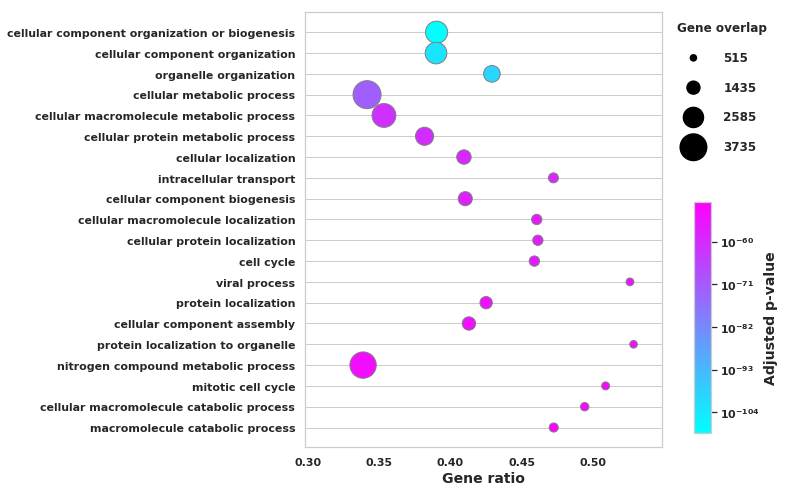

Cluster: NSC2


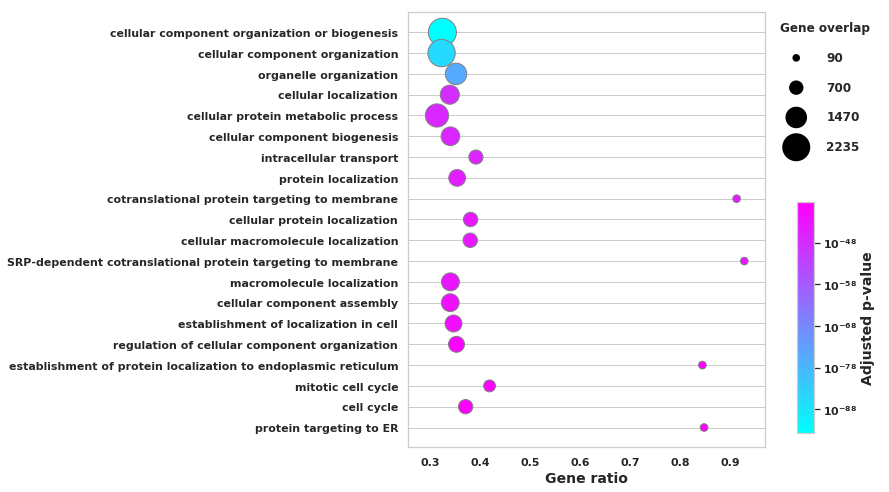

In [41]:
for clust in de_gobp_enrich_coarse:
    # Plot the results
    print(f'Cluster: {clust}')
    if len(de_gobp_enrich_coarse[clust].columns) > 0:
        plot_enrich(de_gobp_enrich_coarse[clust])

Cluster: Glial precursors


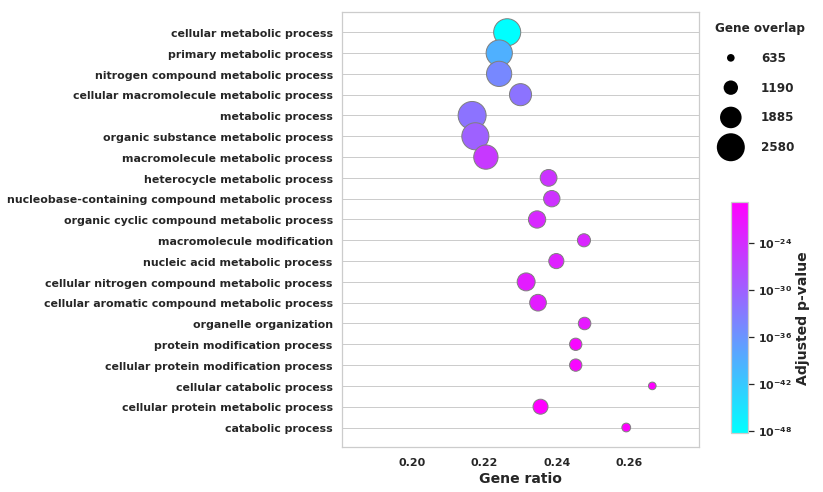

Cluster: Immature neurons


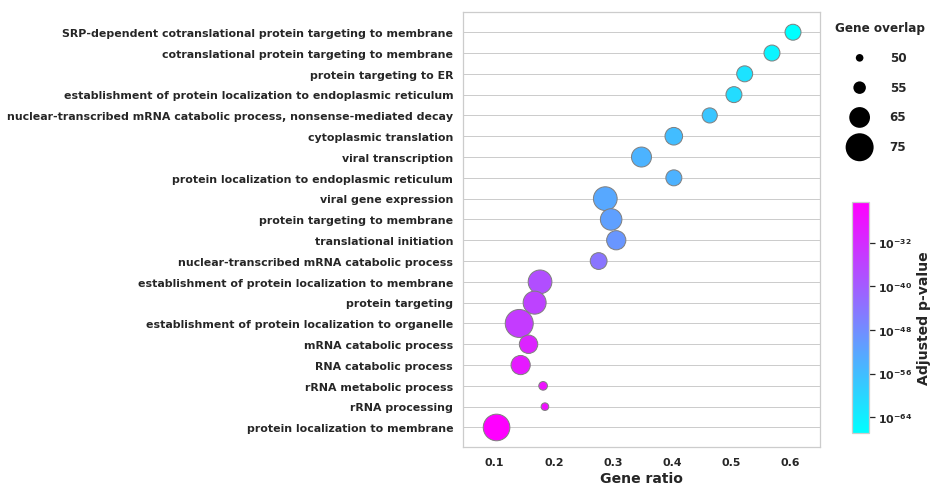

Cluster: NCSC


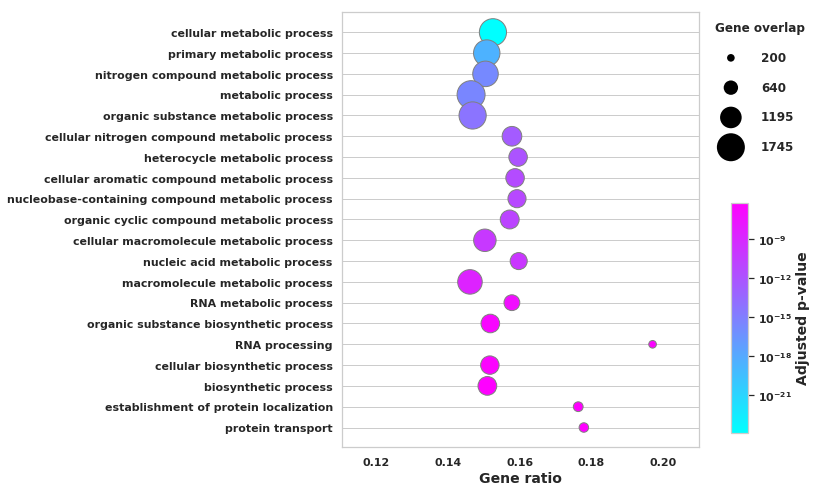

Cluster: NSC1a


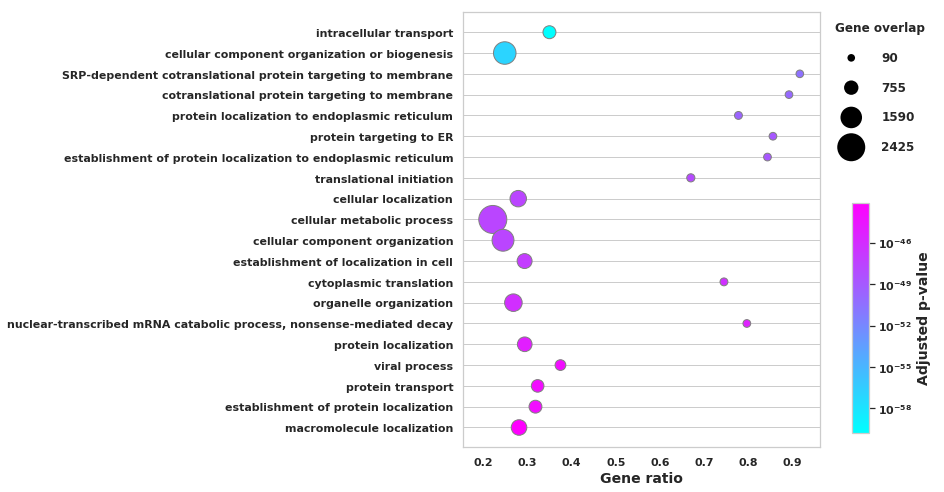

Cluster: NSC1b


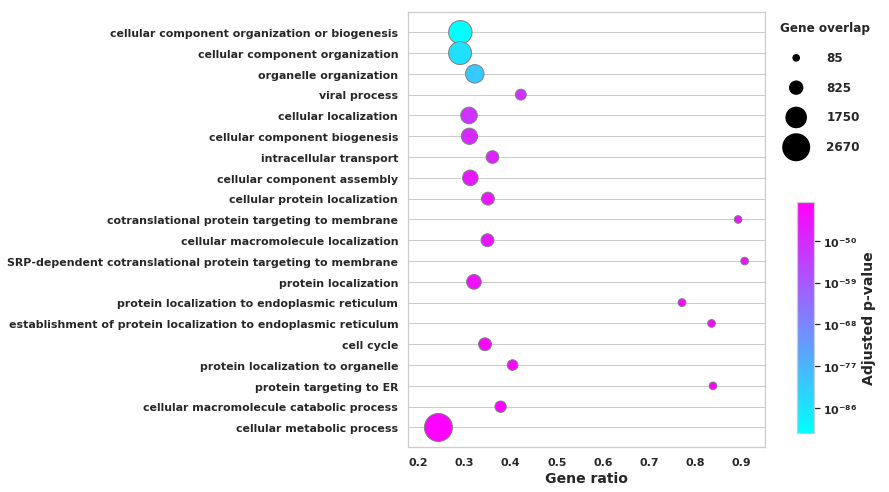

Cluster: NSC2a


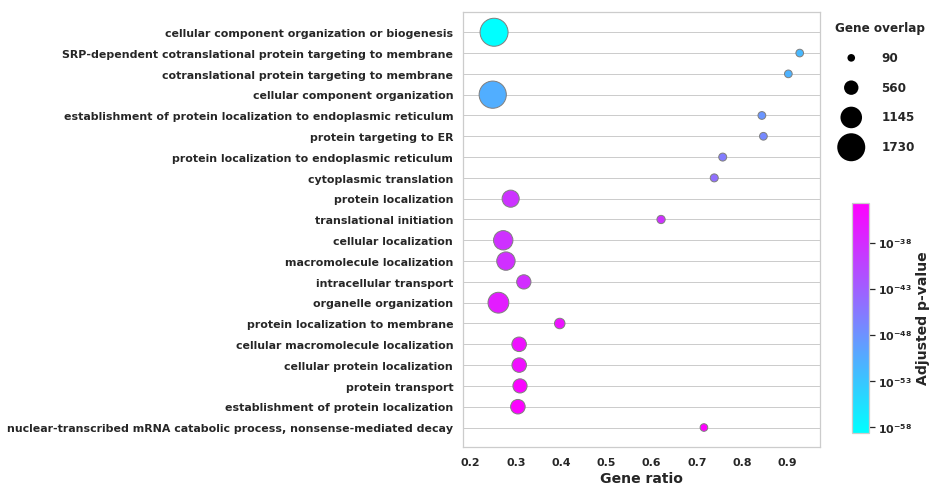

Cluster: NSC2b


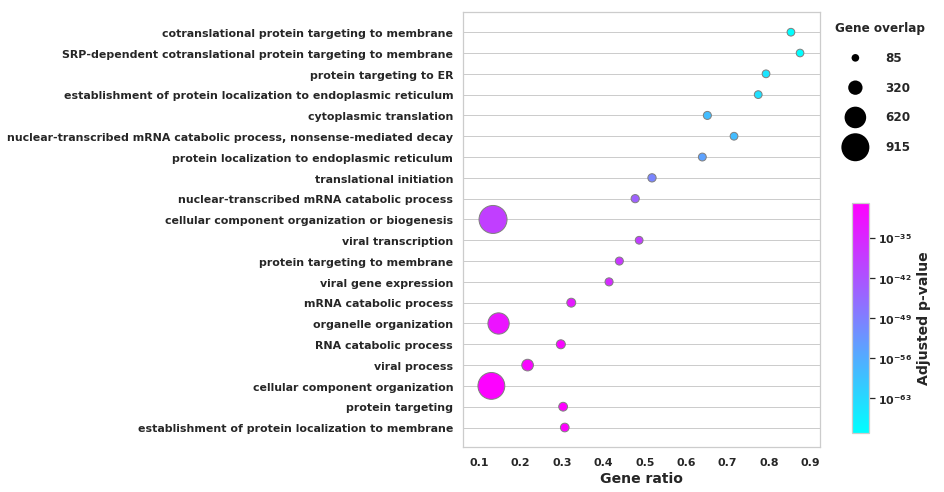

Cluster: Apop. NCSC


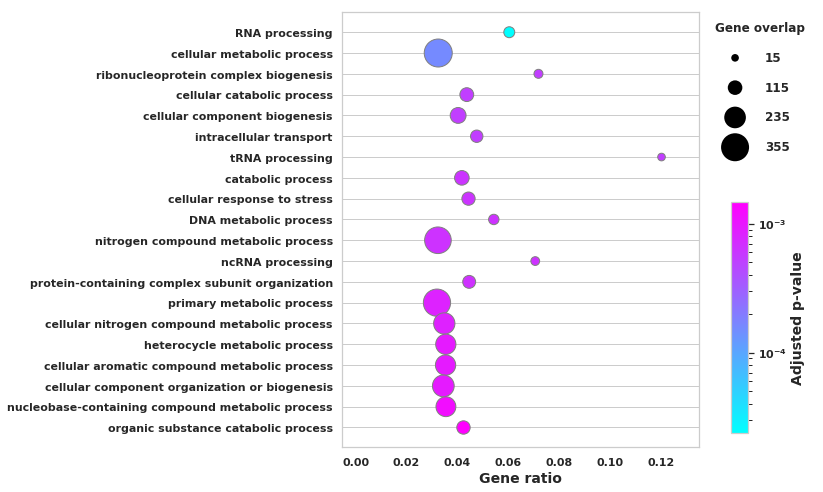

Cluster: Apop. NSC


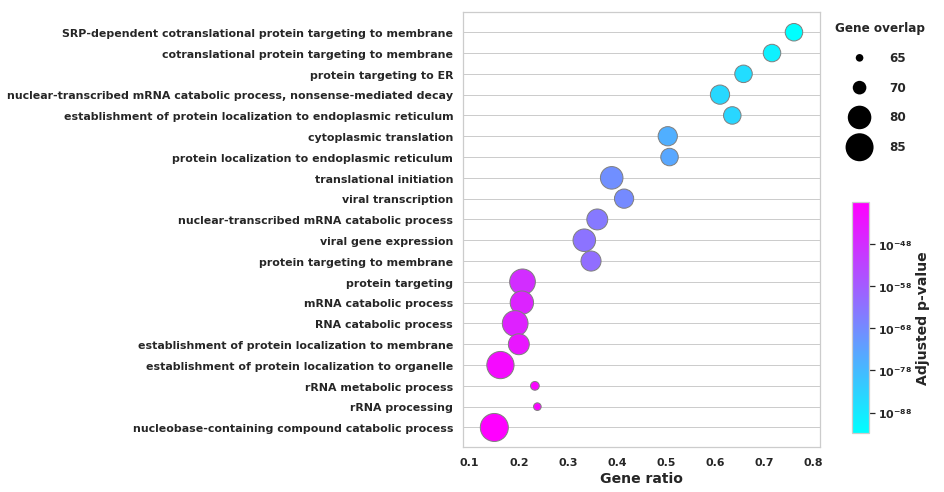

In [42]:
for clust in de_gobp_enrich:
    # Plot the results
    print(f'Cluster: {clust}')
    if len(de_gobp_enrich[clust].columns) > 0:
        plot_enrich(de_gobp_enrich[clust])

Bulk-like:


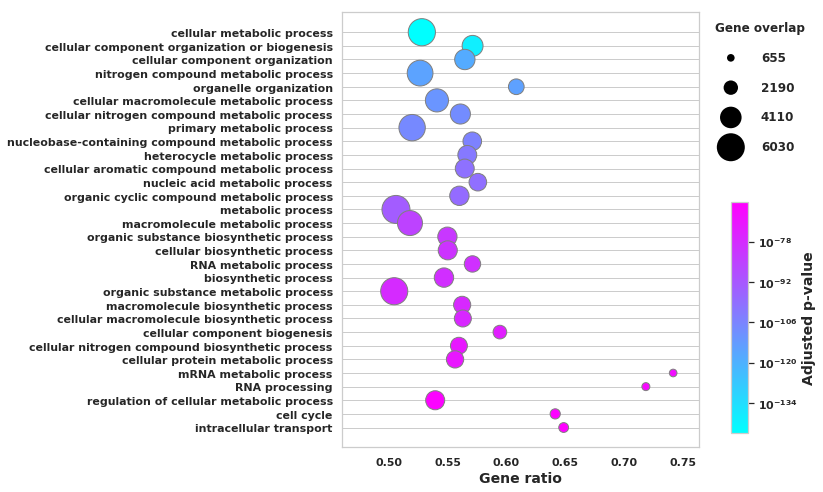

In [43]:
print('Bulk-like:')
if len(bulk_enrich.columns) > 0:
    plot_enrich(bulk_enrich, n_terms=30)

### KEGG Pathway enrichment

In [44]:
de_pathway_enrich_coarse = dict()

for clust in de_signif_coarse:
    tmp = gp.profile(organism='hsapiens', sources=['KEGG', 'REAC'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               domain_scope='annotated', 
                               query=de_signif_coarse[clust]['gene'].tolist())
    
    if tmp is not None:
        tmp.set_index('native', inplace=True)
        de_pathway_enrich_coarse[clust] = tmp.sort_values('p_value').iloc[:,[2,5,7,10,1]]
    else:
        de_pathway_enrich_coarse[clust] = pd.DataFrame()
    
    # Print some results
    print(f'Cluster {clust}:')
    de_pathway_enrich_coarse[clust].iloc[:50,:]

Cluster NSC1:


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-72737    2.859765e-39        120                110  0.916667   
REAC:R-HSA-72613    2.859765e-39        120                110  0.916667   
REAC:R-HSA-72706    5.371407e-39        113                105  0.929204   
REAC:R-HSA-156827   1.169242e-38        112                104  0.928571   
REAC:R-HSA-9633012  1.492994e-35        102                 95  0.931373   
REAC:R-HSA-192823   1.282654e-34         90                 86  0.955556   
REAC:R-HSA-156902   1.282654e-34         90                 86  0.955556   
REAC:R-HSA-72689    2.096122e-34        102                 94  0.921569   
REAC:R-HSA-168255   2.096122e-34        152                125  0.822368   
REAC:R-HSA-1799339  3.215485e-34        113                101  0.893805   
REAC:R-HSA-156842   1.249895e-33         94                 88  0.936170   
REAC:R-HSA-2408557  3.060571e-32         94                 87  0.925532   
REAC:R-HSA-927802   5.474652e-31        116                100  0.862069   
REAC:R-HSA-975957   5.474652e-31        116                100  0.862069   
REAC:R-HSA-72764    5.656418e-31         94                 86  0.914894   
REAC:R-HSA-168273   7.847905e-31        133                110  0.827068   
REAC:R-HSA-975956   1.274515e-30         96                 87  0.906250   
REAC:R-HSA-9711097  2.608973e-29        157                122  0.777070   
REAC:R-HSA-72766    3.947418e-29        292                191  0.654110   
REAC:R-HSA-1640170  8.272421e-26        679                355  0.522828   
REAC:R-HSA-376176   2.912315e-25        217                148  0.682028   
REAC:R-HSA-3700989  1.257716e-23        361                213  0.590028   
REAC:R-HSA-199991   3.012495e-22        625                323  0.516800   
REAC:R-HSA-69278    3.946536e-22        549                291  0.530055   
REAC:R-HSA-9010553  4.279856e-22        171                120  0.701754   
REAC:R-HSA-2408522  7.516991e-22        117                 91  0.777778   
REAC:R-HSA-68877    1.923805e-21        199                133  0.668342   
REAC:R-HSA-8953854  3.345924e-21        662                335  0.506042   
REAC:R-HSA-392499   3.345924e-21       2016                848  0.420635   
REAC:R-HSA-9675108  6.401341e-21        574                298  0.519164   
REAC:R-HSA-422475   2.490773e-20        549                286  0.520947   
KEGG:00190          3.988702e-20        133                 96  0.721805   
REAC:R-HSA-72662    7.245423e-20         60                 55  0.916667   
KEGG:03010          1.170881e-19        153                105  0.686275   
REAC:R-HSA-72702    1.934489e-19         59                 54  0.915254   
REAC:R-HSA-72649    1.934489e-19         59                 54  0.915254   
REAC:R-HSA-2262752  1.017755e-18        582                295  0.506873   
REAC:R-HSA-2555396  6.985349e-18        229                141  0.615721   
REAC:R-HSA-68882    1.310106e-17        228                140  0.614035   
KEGG:04714          1.579317e-17        232                138  0.594828   
REAC:R-HSA-8953897  3.692557e-17        596                296  0.496644   
REAC:R-HSA-69618    1.318863e-16        109                 80  0.733945   
REAC:R-HSA-2500257  2.134783e-16        123                 87  0.707317   
REAC:R-HSA-72695    2.253638e-16         52                 47  0.903846   
REAC:R-HSA-141424   5.885885e-16         92                 70  0.760870   
REAC:R-HSA-141444   5.885885e-16         92                 70  0.760870   
REAC:R-HSA-163200   9.960045e-16        125                 87  0.696000   
REAC:R-HSA-68886    1.026757e-15        407                214  0.525799   
KEGG:05012          2.070476e-15        249                141  0.566265   
REAC:R-HSA-5663220  2.131744e-15        136                 92  0.676471   

                                                                 name  


Cluster NSC2:


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-156827   1.495332e-43        112                101  0.901786   
REAC:R-HSA-156842   3.973831e-43         94                 89  0.946809   
REAC:R-HSA-72706    3.973831e-43        113                101  0.893805   
REAC:R-HSA-192823   8.921562e-43         90                 86  0.955556   
REAC:R-HSA-156902   8.921562e-43         90                 86  0.955556   
REAC:R-HSA-72613    4.874939e-42        120                104  0.866667   
REAC:R-HSA-72737    4.874939e-42        120                104  0.866667   
REAC:R-HSA-9633012  8.229912e-42        102                 93  0.911765   
REAC:R-HSA-72689    1.906647e-40        102                 92  0.901961   
REAC:R-HSA-72764    1.906647e-40         94                 87  0.925532   
REAC:R-HSA-1799339  8.893854e-40        113                 98  0.867257   
REAC:R-HSA-975956   1.124729e-38         96                 87  0.906250   
REAC:R-HSA-2408557  1.305176e-37         94                 85  0.904255   
REAC:R-HSA-9711097  5.700557e-36        157                118  0.751592   
REAC:R-HSA-168255   1.374404e-34        152                114  0.750000   
REAC:R-HSA-927802   2.733287e-33        116                 94  0.810345   
REAC:R-HSA-975957   2.733287e-33        116                 94  0.810345   
REAC:R-HSA-168273   2.130242e-31        133                101  0.759398   
REAC:R-HSA-422475   4.440639e-31        549                271  0.493625   
REAC:R-HSA-9675108  1.083094e-29        574                277  0.482578   
REAC:R-HSA-376176   1.211023e-29        217                138  0.635945   
REAC:R-HSA-72766    2.764979e-26        292                164  0.561644   
REAC:R-HSA-2408522  7.112933e-26        117                 87  0.743590   
REAC:R-HSA-9010553  7.548744e-25        171                111  0.649123   
KEGG:03010          7.401528e-23        153                 99  0.647059   
REAC:R-HSA-2262752  6.913067e-22        582                261  0.448454   
REAC:R-HSA-8953897  3.277973e-21        596                264  0.442953   
REAC:R-HSA-72662    6.303689e-21         60                 52  0.866667   
REAC:R-HSA-72649    2.044264e-20         59                 51  0.864407   
REAC:R-HSA-72702    3.242655e-19         59                 50  0.847458   
REAC:R-HSA-68877    1.757125e-18        199                113  0.567839   
REAC:R-HSA-1640170  3.854702e-18        679                283  0.416789   
REAC:R-HSA-72695    4.905830e-18         52                 45  0.865385   
REAC:R-HSA-199991   8.530844e-18        625                264  0.422400   
REAC:R-HSA-392499   8.975160e-18       2016                690  0.342262   
REAC:R-HSA-69278    6.810477e-16        549                233  0.424408   
REAC:R-HSA-8868773  2.506855e-14        193                103  0.533679   
REAC:R-HSA-6791226  2.772162e-14        183                 99  0.540984   
REAC:R-HSA-3700989  3.657562e-14        361                164  0.454294   
REAC:R-HSA-5663220  4.911887e-13        136                 78  0.573529   
REAC:R-HSA-9716542  6.067898e-13        459                194  0.422658   
REAC:R-HSA-194315   6.067898e-13        459                194  0.422658   
REAC:R-HSA-72312    1.759524e-12        203                103  0.507389   
REAC:R-HSA-8953854  2.549676e-12        662                258  0.389728   
REAC:R-HSA-2500257  4.433552e-12        123                 71  0.577236   
REAC:R-HSA-5653656  4.696251e-12        719                275  0.382476   
REAC:R-HSA-195258   2.023278e-11        319                142  0.445141   
REAC:R-HSA-68886    3.962042e-11        407                171  0.420147   
REAC:R-HSA-141424   8.043934e-11         92                 56  0.608696   
REAC:R-HSA-141444   8.043934e-11         92                 56  0.608696   

                                                                 name  


In [45]:
de_pathway_enrich = dict()

for clust in de_signif:
    tmp = gp.profile(organism='hsapiens', sources=['KEGG', 'REAC'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               domain_scope='annotated', 
                               query=de_signif[clust]['gene'].tolist())
    
    if tmp is not None:
        tmp.set_index('native', inplace=True)
        de_pathway_enrich[clust] = tmp.sort_values('p_value').iloc[:,[2,5,7,10,1]]
    else:
        de_pathway_enrich[clust] = pd.DataFrame()
    
    # Print some results
    print(f'Cluster {clust}:')
    de_pathway_enrich[clust].iloc[:50,:]

Cluster Glial precursors:


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-8953854  9.322309e-14        662                222  0.335347   
REAC:R-HSA-6791226  8.133542e-10        183                 79  0.431694   
REAC:R-HSA-8868773  1.272864e-09        193                 81  0.419689   
REAC:R-HSA-72312    1.272864e-09        203                 84  0.413793   
REAC:R-HSA-74160    3.368922e-09       1476                397  0.268970   
REAC:R-HSA-73857    3.318412e-06       1342                350  0.260805   
REAC:R-HSA-72306    3.776187e-06        103                 46  0.446602   
REAC:R-HSA-446203   5.554506e-06        305                102  0.334426   
KEGG:04140          1.550813e-05        137                 53  0.386861   
REAC:R-HSA-3700989  2.399875e-05        361                114  0.315789   
REAC:R-HSA-168273   2.399875e-05        133                 53  0.398496   
REAC:R-HSA-9711097  4.895582e-05        157                 59  0.375796   
REAC:R-HSA-597592   5.455011e-05       1415                357  0.252297   
REAC:R-HSA-199991   6.801576e-05        625                176  0.281600   
REAC:R-HSA-3781860  1.221172e-04         17                 13  0.764706   
REAC:R-HSA-6784531  1.774805e-04         55                 27  0.490909   
REAC:R-HSA-212436   2.218279e-04       1221                309  0.253071   
REAC:R-HSA-168255   3.134415e-04        152                 55  0.361842   
REAC:R-HSA-191859   3.543342e-04         51                 25  0.490196   
REAC:R-HSA-194441   3.543342e-04         51                 25  0.490196   
REAC:R-HSA-446193   6.109904e-04         78                 33  0.423077   
REAC:R-HSA-162599   6.217036e-04        134                 49  0.365672   
REAC:R-HSA-5633007  6.354906e-04        160                 56  0.350000   
REAC:R-HSA-159231   7.018619e-04         38                 20  0.526316   
REAC:R-HSA-2980766  7.107930e-04         47                 23  0.489362   
REAC:R-HSA-450294   7.869071e-04         63                 28  0.444444   
REAC:R-HSA-168142   9.715110e-04         84                 34  0.404762   
REAC:R-HSA-168176   9.715110e-04         84                 34  0.404762   
REAC:R-HSA-975871   9.715110e-04         84                 34  0.404762   
REAC:R-HSA-159234   9.715110e-04         39                 20  0.512821   
REAC:R-HSA-392499   1.051450e-03       2016                475  0.235615   
REAC:R-HSA-4570464  1.397828e-03         43                 21  0.488372   
KEGG:04910          1.475698e-03        137                 47  0.343066   
KEGG:01100          1.475698e-03       1491                342  0.229376   
REAC:R-HSA-71387    1.633822e-03        285                 86  0.301754   
REAC:R-HSA-5668914  1.633822e-03        241                 75  0.311203   
REAC:R-HSA-156902   1.633822e-03         90                 35  0.388889   
REAC:R-HSA-948021   1.633822e-03        186                 61  0.327957   
REAC:R-HSA-192823   1.633822e-03         90                 35  0.388889   
REAC:R-HSA-156842   1.681313e-03         94                 36  0.382979   
REAC:R-HSA-4085377  1.681313e-03         32                 17  0.531250   
REAC:R-HSA-2408557  1.681313e-03         94                 36  0.382979   
REAC:R-HSA-6811438  1.681313e-03         44                 21  0.477273   
KEGG:04152          1.826013e-03        120                 42  0.350000   
REAC:R-HSA-983168   1.989513e-03        308                 91  0.295455   
REAC:R-HSA-448424   2.286750e-03         71                 29  0.408451   
REAC:R-HSA-168164   2.292359e-03         92                 35  0.380435   
REAC:R-HSA-162587   2.292359e-03        147                 50  0.340136   
REAC:R-HSA-166166   2.459384e-03         96                 36  0.375000   
REAC:R-HSA-937061   2.459384e-03         96                 36  0.375000   

                                                                 name  


Cluster Immature neurons:


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-156902   6.102417e-70         90                 59  0.655556   
REAC:R-HSA-156842   1.635500e-68         94                 59  0.627660   
REAC:R-HSA-192823   1.430324e-66         90                 57  0.633333   
REAC:R-HSA-72689    1.047410e-65        102                 59  0.578431   
REAC:R-HSA-2408557  3.036926e-65         94                 57  0.606383   
REAC:R-HSA-72764    3.036926e-65         94                 57  0.606383   
REAC:R-HSA-975956   1.536207e-64         96                 57  0.593750   
REAC:R-HSA-156827   2.330008e-64        112                 60  0.535714   
REAC:R-HSA-9633012  2.911286e-64        102                 58  0.568627   
REAC:R-HSA-72706    3.892780e-64        113                 60  0.530973   
REAC:R-HSA-72613    4.322461e-62        120                 60  0.500000   
REAC:R-HSA-72737    4.322461e-62        120                 60  0.500000   
REAC:R-HSA-1799339  7.784215e-61        113                 58  0.513274   
REAC:R-HSA-975957   2.372612e-58        116                 57  0.491379   
REAC:R-HSA-927802   2.372612e-58        116                 57  0.491379   
REAC:R-HSA-2408522  4.247401e-58        117                 57  0.487179   
REAC:R-HSA-168273   3.653990e-57        133                 59  0.443609   
REAC:R-HSA-168255   5.855508e-53        152                 59  0.388158   
KEGG:03010          7.721379e-51        153                 58  0.379085   
REAC:R-HSA-9711097  1.517262e-50        157                 58  0.369427   
REAC:R-HSA-6791226  1.956077e-47        183                 59  0.322404   
REAC:R-HSA-9010553  1.063308e-46        171                 57  0.333333   
REAC:R-HSA-8868773  6.167076e-46        193                 59  0.305699   
REAC:R-HSA-72312    1.629779e-44        203                 59  0.290640   
REAC:R-HSA-376176   6.624500e-44        217                 60  0.276498   
REAC:R-HSA-72766    2.564154e-41        292                 65  0.222603   
KEGG:05171          1.224904e-40        231                 59  0.255411   
REAC:R-HSA-72695    2.712231e-31         52                 29  0.557692   
REAC:R-HSA-71291    9.939929e-30        370                 60  0.162162   
REAC:R-HSA-72649    3.466036e-29         59                 29  0.491525   
REAC:R-HSA-72702    3.466036e-29         59                 29  0.491525   
REAC:R-HSA-72662    6.336610e-29         60                 29  0.483333   
REAC:R-HSA-2262752  1.373706e-27        582                 71  0.121993   
REAC:R-HSA-422475   1.515280e-27        549                 69  0.125683   
REAC:R-HSA-8953897  5.833196e-27        596                 71  0.119128   
REAC:R-HSA-9675108  2.247485e-26        574                 69  0.120209   
REAC:R-HSA-8953854  3.364851e-21        662                 67  0.101208   
REAC:R-HSA-5663205  3.620748e-21        909                 79  0.086909   
REAC:R-HSA-1266738  3.696220e-15       1116                 78  0.069892   
REAC:R-HSA-1643685  1.026858e-11       1616                 90  0.055693   
REAC:R-HSA-1430728  3.768824e-10       2077                102  0.049109   
REAC:R-HSA-392499   5.184147e-09       2016                 97  0.048115   
REAC:R-HSA-8876725  1.427103e-03         17                  5  0.294118   
REAC:R-HSA-5339562  1.006742e-02         25                  5  0.200000   
REAC:R-HSA-6790901  2.219374e-02         60                  7  0.116667   
REAC:R-HSA-177539   4.575742e-02          3                  2  0.666667   
REAC:R-HSA-175567   4.575742e-02          3                  2  0.666667   

                                                                 name  
native                                                                 
REAC:R-HSA-156902                            Peptide chain elongation  
REAC:R-HSA-156842                   Eukaryotic Translation Elongation  
REAC:R-HSA-1

Cluster NCSC:


p_value  term_size  intersection_size    recall  \
native                                                                     
KEGG:05168          6.092150e-20        494                141  0.285425   
REAC:R-HSA-72766    3.109878e-04        292                 69  0.236301   
REAC:R-HSA-5419276  3.109878e-04         87                 29  0.333333   
REAC:R-HSA-5368286  3.109878e-04         87                 29  0.333333   
REAC:R-HSA-5389840  3.109878e-04         87                 29  0.333333   
REAC:R-HSA-5368287  3.109878e-04         93                 31  0.333333   
KEGG:01100          1.380380e-03       1491                241  0.161636   
REAC:R-HSA-6811440  1.608181e-03         49                 19  0.387755   
KEGG:04140          7.727989e-03        137                 34  0.248175   
KEGG:01240          7.942342e-03        156                 37  0.237179   
KEGG:03010          9.335637e-03        153                 36  0.235294   
REAC:R-HSA-199991   1.034541e-02        625                116  0.185600   
KEGG:00760          1.110731e-02         35                 13  0.371429   
REAC:R-HSA-8953854  1.940063e-02        662                120  0.181269   
KEGG:04142          2.494270e-02        128                 30  0.234375   
KEGG:00511          3.596533e-02         18                  8  0.444444   
KEGG:04340          4.293331e-02         56                 16  0.285714   
REAC:R-HSA-212436   4.758416e-02       1221                200  0.163800   
REAC:R-HSA-1430728  4.758416e-02       2077                321  0.154550   
REAC:R-HSA-74160    4.758416e-02       1476                236  0.159892   

                                                               name  
native                                                               
KEGG:05168                         Herpes simplex virus 1 infection  
REAC:R-HSA-72766                                        Translation  
REAC:R-HSA-5419276            Mitochondrial translation termination  
REAC:R-HSA-5368286             Mitochondrial translation initiation  
REAC:R-HSA-5389840             Mitochondrial translation elongation  
REAC:R-HSA-5368287                        Mitochondrial translation  
KEGG:01100                                       Metabolic pathways  
REAC:R-HSA-6811440  Retrograde transport at the Trans-Golgi-Network  
KEGG:04140                                       Autophagy - animal  
KEGG:01240                                Biosynthesis of cofactors  
KEGG:03010                                                 Ribosome  
REAC:R-HSA-199991                              Membrane Trafficking  
KEGG:00760                   Nicotinate and nicotinamide metabolism  
REAC:R-HSA-8953854                                Metabolism of RNA  
KEGG:04142                                                 Lysosome  
KEGG:00511                                 Other glycan degradation  
KEGG:04340                               Hedgehog signaling pathway  
REAC:R-HSA-212436                     Generic Transcription Pathway  
REAC:R-HSA-1430728                                       Metabolism  
REAC:R-HSA-74160                    Gene expression (Transcription)

Cluster NSC1a:


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-72737    2.216236e-57        120                109  0.908333   
REAC:R-HSA-72613    2.216236e-57        120                109  0.908333   
REAC:R-HSA-72706    3.126898e-56        113                104  0.920354   
REAC:R-HSA-156827   1.038915e-55        112                103  0.919643   
REAC:R-HSA-72689    5.703391e-51        102                 94  0.921569   
REAC:R-HSA-1799339  2.141125e-50        113                100  0.884956   
REAC:R-HSA-156902   2.907310e-50         90                 86  0.955556   
REAC:R-HSA-192823   2.907310e-50         90                 86  0.955556   
REAC:R-HSA-72766    1.393100e-49        292                181  0.619863   
REAC:R-HSA-156842   2.036904e-49         94                 88  0.936170   
REAC:R-HSA-72764    8.842007e-48         94                 87  0.925532   
REAC:R-HSA-975956   1.740617e-47         96                 88  0.916667   
REAC:R-HSA-2408557  3.088922e-46         94                 86  0.914894   
REAC:R-HSA-9633012  2.628631e-45        102                 90  0.882353   
REAC:R-HSA-975957   1.682089e-44        116                 97  0.836207   
REAC:R-HSA-927802   1.682089e-44        116                 97  0.836207   
REAC:R-HSA-168255   2.063401e-41        152                112  0.736842   
REAC:R-HSA-9010553  6.893949e-40        171                119  0.695906   
REAC:R-HSA-168273   2.741248e-39        133                101  0.759398   
REAC:R-HSA-9711097  3.382467e-39        157                112  0.713376   
REAC:R-HSA-376176   6.535835e-38        217                136  0.626728   
REAC:R-HSA-2408522  1.152994e-34        117                 89  0.760684   
KEGG:03010          3.771198e-34        153                104  0.679739   
REAC:R-HSA-8953854  2.527188e-32        662                277  0.418429   
REAC:R-HSA-72662    5.679474e-28         60                 54  0.900000   
REAC:R-HSA-72649    2.232226e-27         59                 53  0.898305   
REAC:R-HSA-72702    2.232226e-27         59                 53  0.898305   
KEGG:00190          1.059299e-26        133                 87  0.654135   
REAC:R-HSA-2262752  9.280389e-26        582                238  0.408935   
REAC:R-HSA-8953897  7.598826e-25        596                240  0.402685   
REAC:R-HSA-72695    1.621741e-24         52                 47  0.903846   
REAC:R-HSA-392499   1.239695e-23       2016                612  0.303571   
REAC:R-HSA-422475   3.440430e-23        549                222  0.404372   
REAC:R-HSA-9675108  3.287967e-22        574                227  0.395470   
REAC:R-HSA-6791226  6.756956e-22        183                101  0.551913   
KEGG:05012          1.475542e-21        249                122  0.489960   
REAC:R-HSA-8868773  1.759481e-21        193                104  0.538860   
REAC:R-HSA-72312    4.074124e-21        203                107  0.527094   
REAC:R-HSA-163200   1.256936e-20        125                 77  0.616000   
REAC:R-HSA-1428517  2.870846e-19        175                 94  0.537143   
REAC:R-HSA-71291    1.424400e-18        370                157  0.424324   
KEGG:05016          2.789781e-18        306                134  0.437908   
REAC:R-HSA-611105   1.878982e-16        101                 62  0.613861   
KEGG:05020          1.551155e-15        273                118  0.432234   
REAC:R-HSA-5663205  2.785838e-15        909                299  0.328933   
KEGG:04714          5.197515e-15        232                104  0.448276   
REAC:R-HSA-199991   8.100618e-15        625                221  0.353600   
KEGG:05014          5.101590e-14        363                141  0.388430   
REAC:R-HSA-3700989  4.980361e-13        361                141  0.390582   
KEGG:04141          1.979535e-12        170                 79  0.464706   

                                                                 name  


Cluster NSC1b:


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-72706    1.145982e-46        113                101  0.893805   
REAC:R-HSA-156827   2.214079e-46        112                100  0.892857   
REAC:R-HSA-72613    7.862658e-46        120                104  0.866667   
REAC:R-HSA-72737    7.862658e-46        120                104  0.866667   
REAC:R-HSA-156902   1.816529e-44         90                 85  0.944444   
REAC:R-HSA-72689    7.232191e-44        102                 92  0.901961   
REAC:R-HSA-156842   9.677075e-44         94                 87  0.925532   
REAC:R-HSA-192823   5.332427e-43         90                 84  0.933333   
REAC:R-HSA-9633012  1.339840e-42        102                 91  0.892157   
REAC:R-HSA-72764    7.743184e-41         94                 85  0.904255   
REAC:R-HSA-975956   1.336169e-40         96                 86  0.895833   
REAC:R-HSA-1799339  8.879327e-40        113                 95  0.840708   
REAC:R-HSA-2408557  4.245654e-38         94                 83  0.882979   
REAC:R-HSA-927802   6.195879e-38        116                 95  0.818966   
REAC:R-HSA-975957   6.195879e-38        116                 95  0.818966   
REAC:R-HSA-168255   7.457402e-36        152                111  0.730263   
REAC:R-HSA-376176   2.054745e-33        217                137  0.631336   
REAC:R-HSA-9711097  7.740186e-33        157                110  0.700637   
REAC:R-HSA-168273   3.409356e-31        133                 97  0.729323   
REAC:R-HSA-422475   7.981186e-30        549                253  0.460838   
REAC:R-HSA-9675108  9.160046e-29        574                259  0.451220   
REAC:R-HSA-9010553  8.931982e-28        171                110  0.643275   
REAC:R-HSA-72766    1.128766e-27        292                158  0.541096   
REAC:R-HSA-2408522  3.418695e-26        117                 84  0.717949   
KEGG:03010          1.893117e-25        153                 98  0.640523   
REAC:R-HSA-72662    6.782998e-23         60                 52  0.866667   
REAC:R-HSA-72649    2.319630e-22         59                 51  0.864407   
REAC:R-HSA-72702    2.319630e-22         59                 51  0.864407   
REAC:R-HSA-72695    1.043821e-19         52                 45  0.865385   
REAC:R-HSA-1640170  1.561039e-19        679                269  0.396171   
REAC:R-HSA-2262752  1.721395e-18        582                236  0.405498   
KEGG:00190          2.735290e-18        133                 80  0.601504   
REAC:R-HSA-199991   4.987226e-18        625                248  0.396800   
REAC:R-HSA-68877    9.791045e-18        199                106  0.532663   
REAC:R-HSA-8953897  2.453628e-17        596                237  0.397651   
REAC:R-HSA-163200   5.039502e-17        125                 76  0.608000   
KEGG:04714          7.434800e-17        232                114  0.491379   
REAC:R-HSA-392499   1.146750e-16       2016                634  0.314484   
REAC:R-HSA-3700989  1.512368e-16        361                160  0.443213   
REAC:R-HSA-69278    3.589786e-16        549                219  0.398907   
REAC:R-HSA-8953854  5.190193e-16        662                253  0.382175   
KEGG:05171          4.477292e-15        231                110  0.476190   
REAC:R-HSA-2500257  3.120933e-14        123                 71  0.577236   
KEGG:05016          6.429258e-14        306                132  0.431373   
REAC:R-HSA-195258   1.354029e-13        319                139  0.435737   
REAC:R-HSA-5663220  1.372275e-13        136                 75  0.551471   
REAC:R-HSA-611105   1.767866e-13        101                 61  0.603960   
REAC:R-HSA-5663205  2.195511e-13        909                316  0.347635   
REAC:R-HSA-69618    2.439716e-13        109                 64  0.587156   
REAC:R-HSA-141424   2.595181e-13         92                 57  0.619565   

                                                                 name  


Cluster NSC2a:


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-156827   4.815034e-52        112                100  0.892857   
REAC:R-HSA-72706    1.678030e-51        113                100  0.884956   
REAC:R-HSA-156902   3.181408e-51         90                 86  0.955556   
REAC:R-HSA-72689    9.330931e-51        102                 93  0.911765   
REAC:R-HSA-156842   1.578543e-50         94                 88  0.936170   
REAC:R-HSA-192823   1.089772e-49         90                 85  0.944444   
REAC:R-HSA-72737    1.540267e-49        120                102  0.850000   
REAC:R-HSA-9633012  1.540267e-49        102                 92  0.901961   
REAC:R-HSA-72613    1.540267e-49        120                102  0.850000   
REAC:R-HSA-1799339  6.213704e-48        113                 97  0.858407   
REAC:R-HSA-72764    1.557704e-47         94                 86  0.914894   
REAC:R-HSA-975956   2.680092e-47         96                 87  0.906250   
REAC:R-HSA-2408557  1.696572e-44         94                 84  0.893617   
REAC:R-HSA-9711097  1.033338e-42        157                114  0.726115   
REAC:R-HSA-927802   1.649048e-37        116                 90  0.775862   
REAC:R-HSA-975957   1.649048e-37        116                 90  0.775862   
REAC:R-HSA-168273   1.681701e-33        133                 94  0.706767   
REAC:R-HSA-168255   2.449859e-33        152                102  0.671053   
REAC:R-HSA-2408522  9.825863e-33        117                 86  0.735043   
REAC:R-HSA-376176   1.156364e-32        217                127  0.585253   
REAC:R-HSA-72766    3.199438e-31        292                152  0.520548   
REAC:R-HSA-422475   5.435344e-30        549                232  0.422587   
REAC:R-HSA-9675108  8.784562e-30        574                239  0.416376   
REAC:R-HSA-9010553  2.017523e-29        171                105  0.614035   
KEGG:03010          3.582425e-27        153                 95  0.620915   
REAC:R-HSA-72662    1.386030e-24         60                 51  0.850000   
REAC:R-HSA-72649    5.560311e-24         59                 50  0.847458   
REAC:R-HSA-72702    1.051272e-22         59                 49  0.830508   
REAC:R-HSA-2262752  1.095824e-22        582                225  0.386598   
REAC:R-HSA-8953897  1.095824e-22        596                229  0.384228   
REAC:R-HSA-72695    2.270723e-22         52                 45  0.865385   
REAC:R-HSA-6791226  1.719394e-20        183                 97  0.530055   
REAC:R-HSA-8868773  3.501155e-20        193                100  0.518135   
REAC:R-HSA-72312    1.045903e-18        203                101  0.497537   
REAC:R-HSA-392499   1.128028e-16       2016                565  0.280258   
KEGG:00190          1.976151e-14        133                 70  0.526316   
KEGG:05171          4.290067e-14        231                101  0.437229   
REAC:R-HSA-199991   1.010813e-13        625                212  0.339200   
REAC:R-HSA-3700989  1.530945e-13        361                139  0.385042   
REAC:R-HSA-163200   4.136351e-13        125                 65  0.520000   
REAC:R-HSA-8953854  5.082892e-12        662                216  0.326284   
KEGG:04714          1.156823e-11        232                 96  0.413793   
REAC:R-HSA-5663205  1.394845e-11        909                277  0.304730   
REAC:R-HSA-611105   7.273575e-11        101                 53  0.524752   
REAC:R-HSA-1266738  4.714637e-10       1116                321  0.287634   
REAC:R-HSA-1643685  4.851427e-10       1616                439  0.271658   
REAC:R-HSA-9006934  1.062417e-09        486                162  0.333333   
REAC:R-HSA-5628897  1.271210e-09         84                 45  0.535714   
REAC:R-HSA-1428517  2.774622e-09        175                 74  0.422857   
REAC:R-HSA-5653656  2.956022e-09        719                220  0.305981   

                                                                 name  


Cluster NSC2b:


p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-156902   3.476717e-74         90                 85  0.944444   
REAC:R-HSA-156827   3.476717e-74        112                 96  0.857143   
REAC:R-HSA-156842   4.364556e-74         94                 87  0.925532   
REAC:R-HSA-192823   2.222551e-72         90                 84  0.933333   
REAC:R-HSA-72706    2.631476e-72        113                 95  0.840708   
REAC:R-HSA-72613    7.082764e-71        120                 97  0.808333   
REAC:R-HSA-72737    7.082764e-71        120                 97  0.808333   
REAC:R-HSA-9633012  7.082764e-71        102                 89  0.872549   
REAC:R-HSA-72689    7.082764e-71        102                 89  0.872549   
REAC:R-HSA-72764    1.110865e-70         94                 85  0.904255   
REAC:R-HSA-975956   6.802215e-69         96                 85  0.885417   
REAC:R-HSA-1799339  8.570522e-68        113                 92  0.814159   
REAC:R-HSA-2408557  4.509931e-67         94                 83  0.882979   
REAC:R-HSA-9711097  1.820771e-61        157                104  0.662420   
REAC:R-HSA-975957   3.883434e-57        116                 86  0.741379   
REAC:R-HSA-927802   3.883434e-57        116                 86  0.741379   
REAC:R-HSA-2408522  6.984128e-54        117                 84  0.717949   
REAC:R-HSA-168255   2.587799e-50        152                 93  0.611842   
REAC:R-HSA-168273   2.507637e-49        133                 86  0.646617   
KEGG:03010          1.786112e-45        153                 89  0.581699   
REAC:R-HSA-72766    5.046972e-45        292                125  0.428082   
REAC:R-HSA-9010553  3.580944e-44        171                 93  0.543860   
REAC:R-HSA-376176   2.765953e-38        217                 99  0.456221   
REAC:R-HSA-72662    2.742172e-34         60                 48  0.800000   
REAC:R-HSA-6791226  1.855836e-33        183                 85  0.464481   
REAC:R-HSA-72649    1.958862e-33         59                 47  0.796610   
REAC:R-HSA-8868773  3.396219e-32        193                 86  0.445596   
REAC:R-HSA-72702    5.717664e-32         59                 46  0.779661   
REAC:R-HSA-72695    6.964808e-32         52                 43  0.826923   
REAC:R-HSA-2262752  1.478853e-31        582                163  0.280069   
REAC:R-HSA-72312    4.548947e-31        203                 87  0.428571   
REAC:R-HSA-8953897  3.122638e-30        596                163  0.273490   
KEGG:05171          3.950459e-29        231                 91  0.393939   
REAC:R-HSA-422475   5.316850e-26        549                147  0.267760   
REAC:R-HSA-9675108  2.340173e-25        574                150  0.261324   
REAC:R-HSA-71291    5.404966e-22        370                108  0.291892   
REAC:R-HSA-392499   7.768944e-19       2016                337  0.167163   
REAC:R-HSA-5663205  9.542916e-17        909                182  0.200220   
KEGG:00190          4.449582e-16        133                 52  0.390977   
REAC:R-HSA-68877    1.067007e-15        199                 65  0.326633   
REAC:R-HSA-1640170  4.915397e-14        679                141  0.207658   
REAC:R-HSA-69278    6.653583e-14        549                121  0.220401   
REAC:R-HSA-8953854  1.675483e-13        662                137  0.206949   
KEGG:05415          3.554065e-12        203                 60  0.295567   
REAC:R-HSA-2500257  1.880421e-11        123                 43  0.349593   
REAC:R-HSA-163200   3.461116e-11        125                 43  0.344000   
REAC:R-HSA-5663220  4.783617e-11        136                 45  0.330882   
REAC:R-HSA-1643685  9.873728e-11       1616                256  0.158416   
KEGG:05012          4.454530e-10        249                 64  0.257028   
REAC:R-HSA-68886    6.449430e-10        407                 89  0.218673   

                                                                 name  


Cluster Apop. NCSC:


p_value  term_size  intersection_size    recall  \
native                                                                 
REAC:R-HSA-8953854  0.000032        662                 47  0.070997   

                                 name  
native                                 
REAC:R-HSA-8953854  Metabolism of RNA

Cluster Apop. NSC:


p_value  term_size  intersection_size    recall  \
native                                                                      
REAC:R-HSA-156902   3.281518e-101         90                 75  0.833333   
REAC:R-HSA-156842    1.183606e-98         94                 75  0.797872   
REAC:R-HSA-975956    1.640645e-97         96                 75  0.781250   
REAC:R-HSA-192823    3.346709e-97         90                 73  0.811111   
REAC:R-HSA-2408557   1.041574e-94         94                 73  0.776596   
REAC:R-HSA-72764     1.041574e-94         94                 73  0.776596   
REAC:R-HSA-72689     2.807976e-94        102                 75  0.735294   
REAC:R-HSA-156827    3.607501e-93        112                 77  0.687500   
REAC:R-HSA-72706     9.249280e-91        113                 76  0.672566   
REAC:R-HSA-9633012   2.680108e-90        102                 73  0.715686   
REAC:R-HSA-72737     1.172858e-89        120                 77  0.641667   
REAC:R-HSA-72613     1.172858e-89        120                 77  0.641667   
REAC:R-HSA-927802    1.189860e-87        116                 75  0.646552   
REAC:R-HSA-975957    1.189860e-87        116                 75  0.646552   
REAC:R-HSA-1799339   4.287267e-87        113                 74  0.654867   
REAC:R-HSA-2408522   2.212665e-85        117                 74  0.632479   
REAC:R-HSA-168273    1.313233e-77        133                 73  0.548872   
REAC:R-HSA-168255    1.612242e-73        152                 74  0.486842   
REAC:R-HSA-9010553   9.223623e-72        171                 76  0.444444   
REAC:R-HSA-9711097   1.304181e-70        157                 73  0.464968   
KEGG:03010           7.322934e-68        153                 73  0.477124   
REAC:R-HSA-6791226   5.071443e-66        183                 74  0.404372   
REAC:R-HSA-376176    4.565494e-65        217                 78  0.359447   
REAC:R-HSA-8868773   5.446402e-64        193                 74  0.383420   
REAC:R-HSA-72312     4.453665e-62        203                 74  0.364532   
REAC:R-HSA-72766     1.714959e-57        292                 81  0.277397   
KEGG:05171           1.979419e-52        231                 73  0.316017   
REAC:R-HSA-71291     8.484026e-50        370                 82  0.221622   
REAC:R-HSA-2262752   2.609353e-40        582                 89  0.152921   
REAC:R-HSA-8953897   1.844880e-39        596                 89  0.149329   
REAC:R-HSA-9675108   5.193976e-39        574                 87  0.151568   
REAC:R-HSA-422475    9.127673e-39        549                 85  0.154827   
REAC:R-HSA-72649     4.719745e-38         59                 35  0.593220   
REAC:R-HSA-72662     1.070186e-37         60                 35  0.583333   
REAC:R-HSA-72695     2.710984e-37         52                 33  0.634615   
REAC:R-HSA-72702     2.300012e-36         59                 34  0.576271   
REAC:R-HSA-8953854   8.472542e-36        662                 89  0.134441   
REAC:R-HSA-5663205   1.206177e-28        909                 94  0.103410   
REAC:R-HSA-392499    1.568969e-23       2016                135  0.066964   
REAC:R-HSA-1266738   4.975783e-20       1116                 91  0.081541   
REAC:R-HSA-1643685   4.381009e-17       1616                107  0.066213   
REAC:R-HSA-1430728   3.113463e-16       2077                123  0.059220   

                                                                 name  
native                                                                 
REAC:R-HSA-156902                            Peptide chain elongation  
REAC:R-HSA-156842                   Eukaryotic Translation Elongation  
REAC:R-HSA-975956   Nonsense Mediated Decay (NMD) independent of t...  
REAC:R-HSA-192823                              Viral mRNA Translation  
REAC:R-HSA-2408557                           Selenocysteine synthesis  
REAC:R-HSA-72764                   Eukaryotic Translation Termination  
REAC:R-HSA-72689             Formation of a pool of free 40S 

In [46]:
#Bulk-like
bulk_enrich_pw = tmp = gp.profile(organism='hsapiens', sources=['KEGG', 'REAC'], user_threshold=0.05,
                               significance_threshold_method='fdr', 
                               domain_scope='annotated', 
                               query=bulk_res_filt['gene'].tolist())
    
if bulk_enrich_pw is not None:
    bulk_enrich_pw.set_index('native', inplace=True)
    bulk_enrich_pw.sort_values('p_value').iloc[:,[2,5,7,10,1]]
else:
    bulk_enrich_pw = pd.DataFrame()
    
# Print some results
print('Bulk-like:')
bulk_enrich_pw.iloc[:50,:]

p_value  term_size  intersection_size    recall  \
native                                                                     
REAC:R-HSA-8953854  3.154457e-51        662                513  0.774924   
REAC:R-HSA-72766    1.418447e-30        292                241  0.825342   
REAC:R-HSA-168255   7.670215e-28        152                140  0.921053   
REAC:R-HSA-3700989  9.963106e-28        361                281  0.778393   
REAC:R-HSA-1640170  1.199710e-26        679                472  0.695140   
REAC:R-HSA-72706    1.381083e-26        113                109  0.964602   
REAC:R-HSA-156827   2.359024e-26        112                108  0.964286   
REAC:R-HSA-72613    3.754007e-26        120                114  0.950000   
REAC:R-HSA-72737    3.754007e-26        120                114  0.950000   
REAC:R-HSA-168273   3.314452e-25        133                123  0.924812   
REAC:R-HSA-1799339  3.416174e-24        113                107  0.946903   
REAC:R-HSA-9711097  7.413500e-24        157                139  0.885350   
REAC:R-HSA-74160    8.119938e-24       1476                909  0.615854   
REAC:R-HSA-72689    1.061182e-23        102                 98  0.960784   
REAC:R-HSA-9633012  1.061182e-23        102                 98  0.960784   
REAC:R-HSA-392499   1.359491e-23       2016               1197  0.593750   
REAC:R-HSA-72203    1.493004e-23        237                193  0.814346   
REAC:R-HSA-72172    5.011859e-23        186                158  0.849462   
REAC:R-HSA-927802   6.193445e-23        116                108  0.931034   
REAC:R-HSA-975957   6.193445e-23        116                108  0.931034   
REAC:R-HSA-72163    6.636966e-22        178                151  0.848315   
REAC:R-HSA-68877    8.999716e-22        199                165  0.829146   
REAC:R-HSA-156902   1.013799e-21         90                 87  0.966667   
REAC:R-HSA-192823   1.013799e-21         90                 87  0.966667   
REAC:R-HSA-156842   1.441997e-21         94                 90  0.957447   
...                          ...        ...                ...       ...   
REAC:R-HSA-5610785  4.601537e-02         60                 39  0.650000   
REAC:R-HSA-174417   4.601537e-02         34                 24  0.705882   
REAC:R-HSA-180585   4.610342e-02         53                 35  0.660377   
REAC:R-HSA-169911   4.610342e-02         53                 35  0.660377   
REAC:R-HSA-6811436  4.610342e-02         53                 35  0.660377   
REAC:R-HSA-5619107  4.610342e-02         29                 21  0.724138   
REAC:R-HSA-2151201  4.610342e-02         53                 35  0.660377   
REAC:R-HSA-170822   4.610342e-02         29                 21  0.724138   
REAC:R-HSA-2465910  4.638403e-02         10                  9  0.900000   
REAC:R-HSA-3215018  4.638403e-02         10                  9  0.900000   
REAC:R-HSA-163685   4.638403e-02        107                 65  0.607477   
REAC:R-HSA-2470946  4.638403e-02         10                  9  0.900000   
REAC:R-HSA-390450   4.638403e-02         10                  9  0.900000   
KEGG:04014          4.652975e-02        231                124  0.536797   
REAC:R-HSA-202670   4.695746e-02         13                 11  0.846154   
REAC:R-HSA-418885   4.695746e-02         13                 11  0.846154   
KEGG:05230          4.761201e-02         70                 42  0.600000   
KEGG:05120          4.761201e-02         70                 42  0.600000   
KEGG:04962          4.974564e-02         44                 28  0.636364   
KEGG:05134          4.974564e-02         57                 35  0.614035   
KEGG:04914          4.980045e-02         99                 57  0.575758   
REAC:R-HSA-4641257  4.994484e-02         55                 36  0.654545   
REAC:R-HSA-174113   4.994484e-02         55                 36  0.654545   
REAC:R-HSA-8854050  4.994484e-02         55                 36  0.654545   
REAC:R-HSA-8939902  4.994484e-02         71                 45  0.633803 

Bulk-like:


source                                               name  \
native                                                                         
REAC:R-HSA-8953854   REAC                                  Metabolism of RNA   
REAC:R-HSA-72766     REAC                                        Translation   
REAC:R-HSA-168255    REAC                                Influenza Infection   
REAC:R-HSA-3700989   REAC                 Transcriptional Regulation by TP53   
REAC:R-HSA-1640170   REAC                                         Cell Cycle   
REAC:R-HSA-72706     REAC  GTP hydrolysis and joining of the 60S ribosoma...   
REAC:R-HSA-156827    REAC  L13a-mediated translational silencing of Cerul...   
REAC:R-HSA-72613     REAC                  Eukaryotic Translation Initiation   
REAC:R-HSA-72737     REAC               Cap-dependent Translation Initiation   
REAC:R-HSA-168273    REAC  Influenza Viral RNA Transcription and Replication   
REAC:R-HSA-1799339   REAC  SRP-dependent cotranslational protein targetin...   
REAC:R-HSA-9711097   REAC                    Cellular response to starvation   
REAC:R-HSA-74160     REAC                    Gene expression (Transcription)   
REAC:R-HSA-72689     REAC           Formation of a pool of free 40S subunits   
REAC:R-HSA-9633012   REAC  Response of EIF2AK4 (GCN2) to amino acid defic...   
REAC:R-HSA-392499    REAC                             Metabolism of proteins   
REAC:R-HSA-72203     REAC    Processing of Capped Intron-Containing Pre-mRNA   
REAC:R-HSA-72172     REAC                                      mRNA Splicing   
REAC:R-HSA-927802    REAC                      Nonsense-Mediated Decay (NMD)   
REAC:R-HSA-975957    REAC  Nonsense Mediated Decay (NMD) enhanced by the ...   
REAC:R-HSA-72163     REAC                      mRNA Splicing - Major Pathway   
REAC:R-HSA-68877     REAC                               Mitotic Prometaphase   
REAC:R-HSA-156902    REAC                           Peptide chain elongation   
REAC:R-HSA-192823    REAC                             Viral mRNA Translation   
REAC:R-HSA-156842    REAC                  Eukaryotic Translation Elongation   
REAC:R-HSA-2408557   REAC                           Selenocysteine synthesis   
REAC:R-HSA-69278     REAC                                Cell Cycle, Mitotic   
REAC:R-HSA-376176    REAC                        Signaling by ROBO receptors   
REAC:R-HSA-73857     REAC                    RNA Polymerase II Transcription   
REAC:R-HSA-72764     REAC                 Eukaryotic Translation Termination   
REAC:R-HSA-2262752   REAC                       Cellular responses to stress   
REAC:R-HSA-975956    REAC  Nonsense Mediated Decay (NMD) independent of t...   
REAC:R-HSA-163200    REAC  Respiratory electron transport, ATP synthesis ...   
REAC:R-HSA-8868773   REAC         rRNA processing in the nucleus and cytosol   
REAC:R-HSA-1428517   REAC  The citric acid (TCA) cycle and respiratory el...   
REAC:R-HSA-6791226   REAC  Major pathway of rRNA processing in the nucleo...   
REAC:R-HSA-2555396   REAC                     Mitotic Metaphase and Anaphase   
REAC:R-HSA-72312     REAC                                    rRNA processing   
REAC:R-HSA-68882     REAC                                   Mitotic Anaphase   
REAC:R-HSA-8953897   REAC             Cellular responses to external stimuli   
REAC:R-HSA-611105    REAC                     Respiratory electron transport   
KEGG:05016           KEGG                                 Huntington disease   
KEGG:05014           KEGG                      Amyotrophic lateral sclerosis   
KEGG:05012           KEGG                                  Parkinson disease   
KEGG:03010           KEGG                                           Ribosome   
KEGG:04714           KEGG                                      Thermogenesis   
REAC:R-HSA-69618     REAC                         Mitotic Spindle Checkpoint   
REAC:R-HSA-199991    REAC                               Membrane Trafficking   
REAC:R-HSA-9010553 

Cluster: NSC1


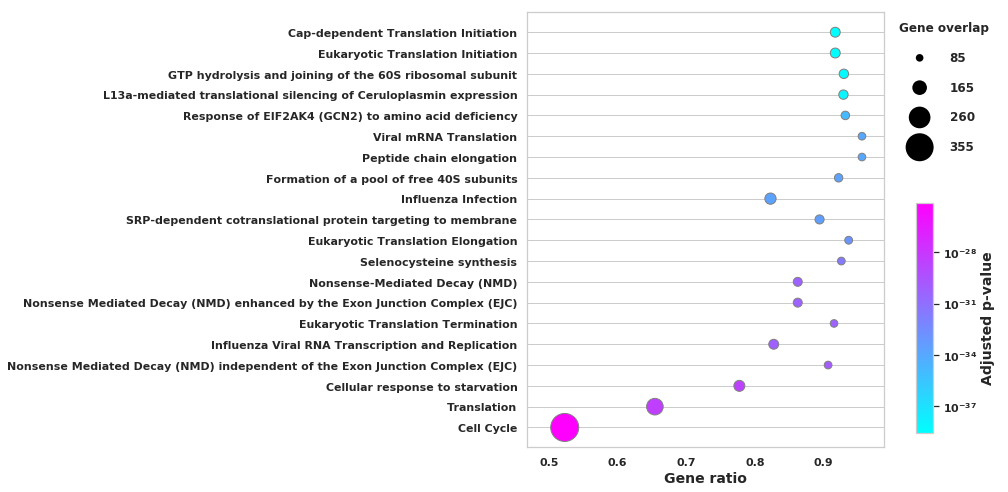

Cluster: NSC2


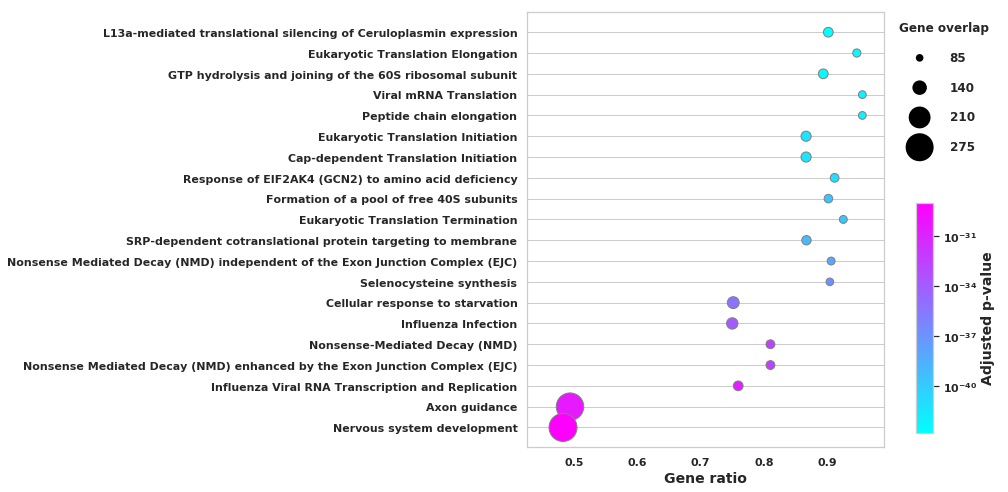

In [47]:
for clust in de_pathway_enrich_coarse:
    # Plot the results
    print(f'Cluster: {clust}')
    if len(de_pathway_enrich_coarse[clust].columns) > 0:
        plot_enrich(de_pathway_enrich_coarse[clust])

Cluster: Glial precursors


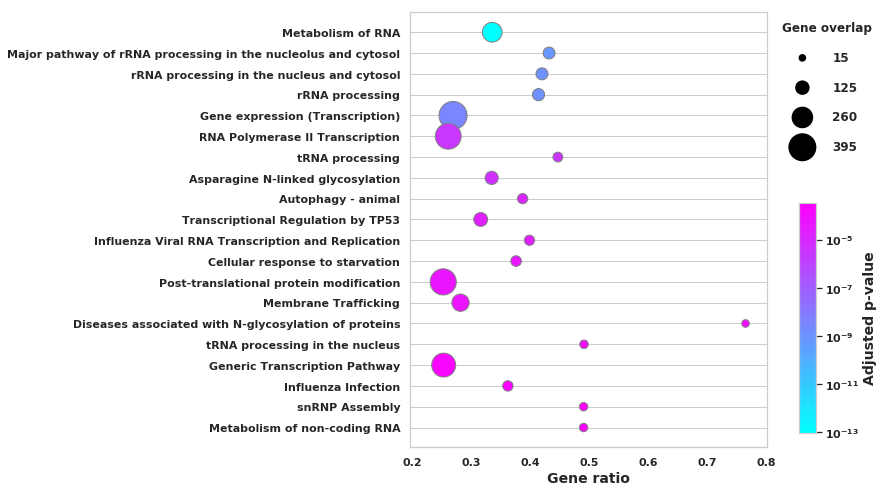

Cluster: Immature neurons


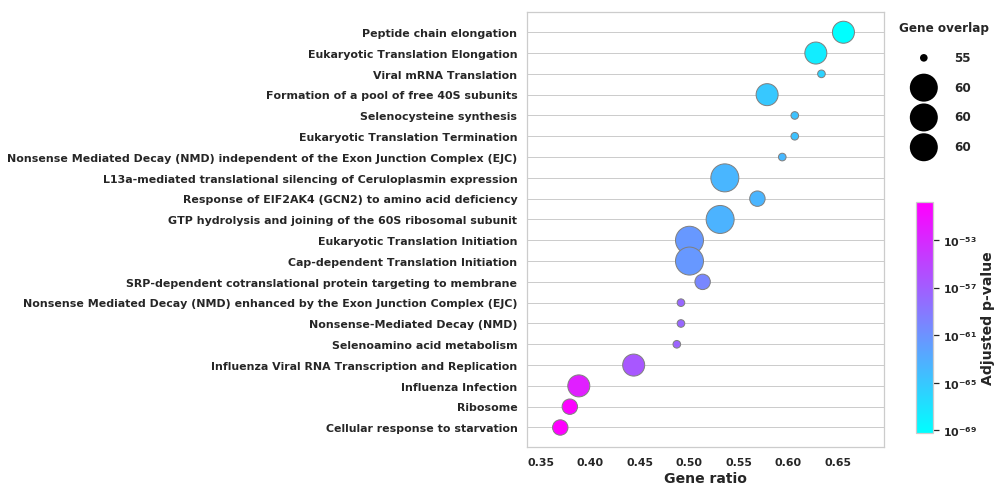

Cluster: NCSC


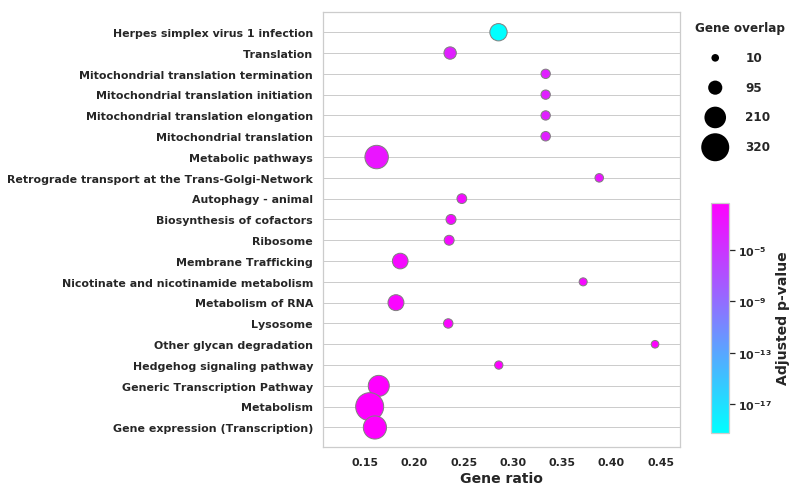

Cluster: NSC1a


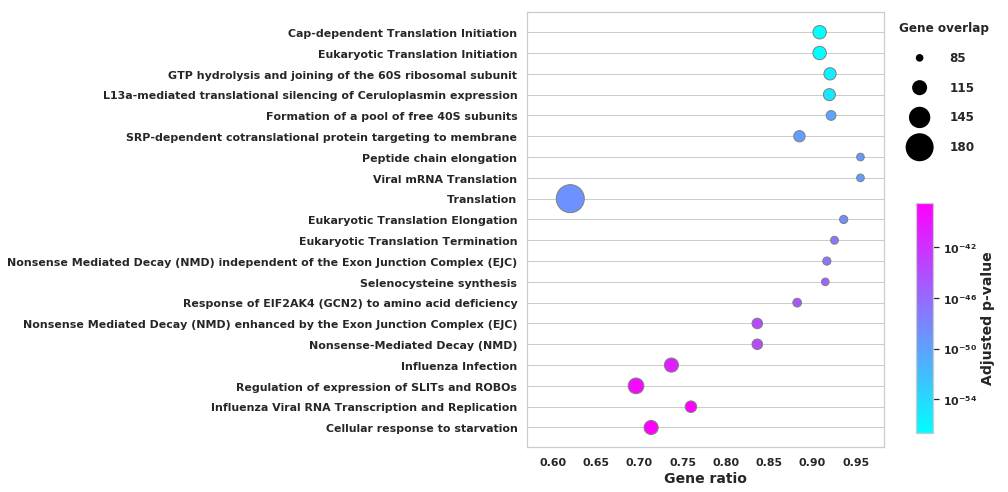

Cluster: NSC1b


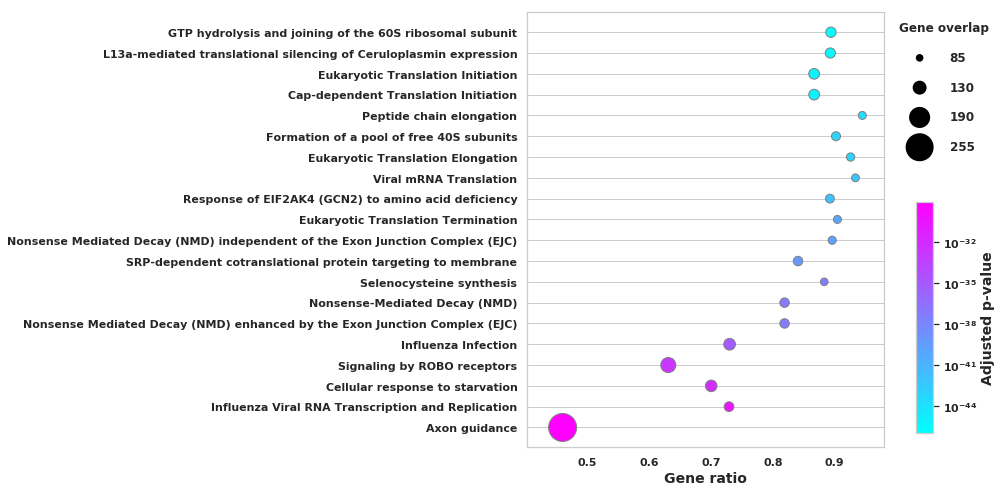

Cluster: NSC2a


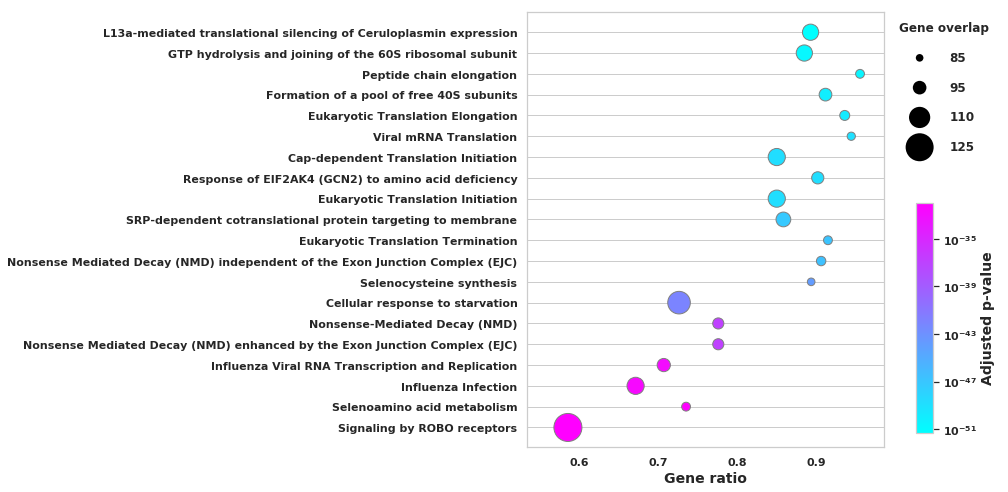

Cluster: NSC2b


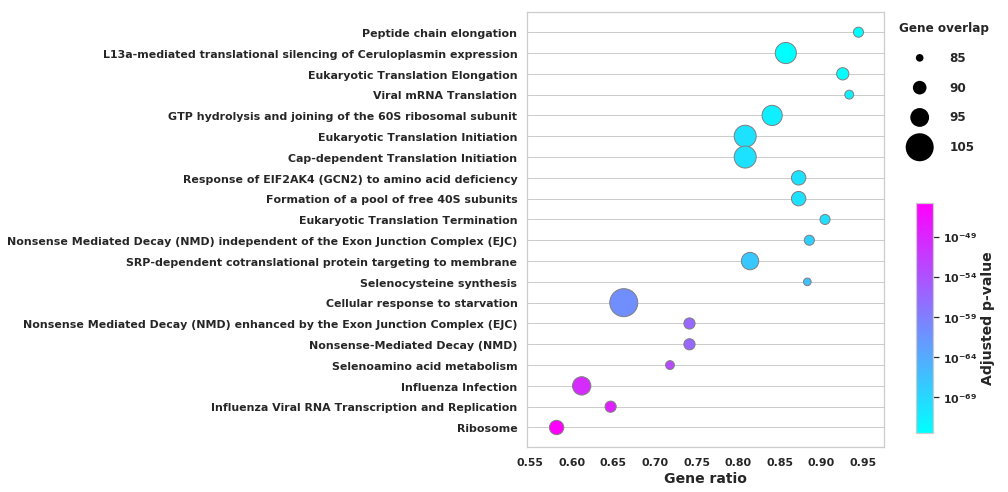

Cluster: Apop. NCSC


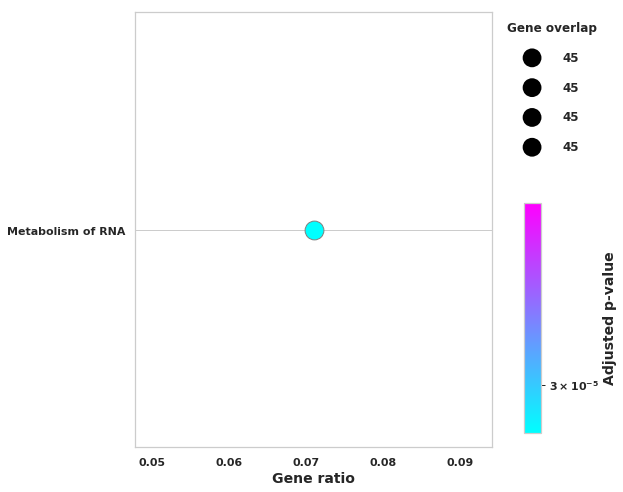

Cluster: Apop. NSC


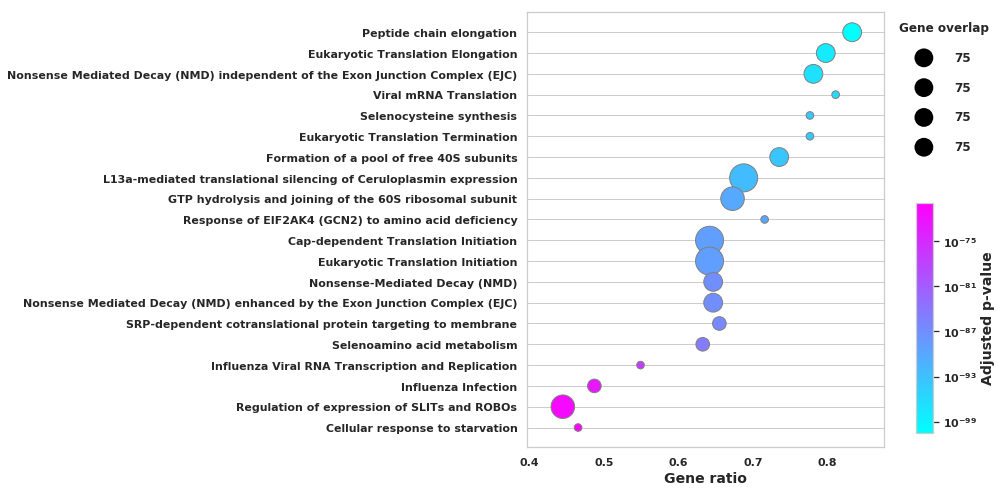

In [48]:
for clust in de_pathway_enrich:
    # Plot the results
    print(f'Cluster: {clust}')
    if len(de_pathway_enrich[clust].columns) > 0:
        plot_enrich(de_pathway_enrich[clust])

Bulk-like:


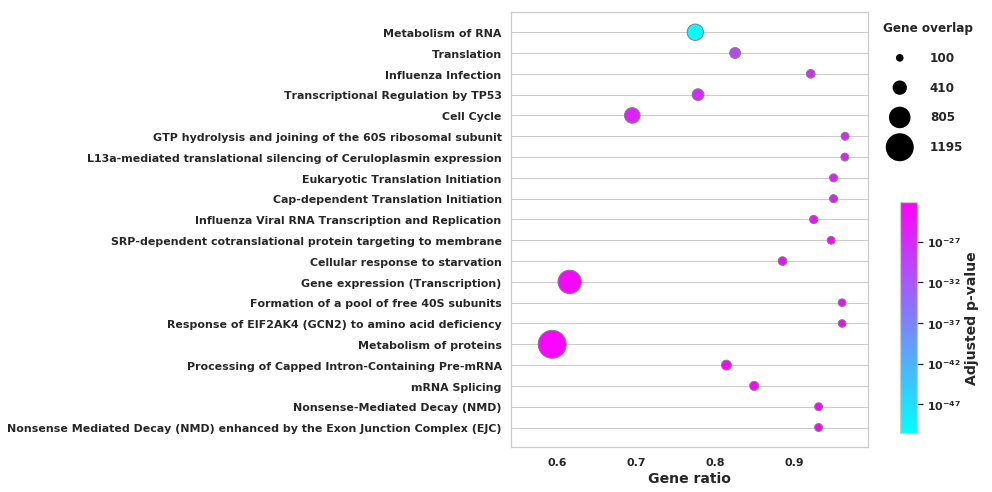

In [49]:
print('Bulk-like:')
if len(bulk_enrich_pw.columns) > 0:
    plot_enrich(bulk_enrich_pw)

# Check individual gene

### Foxa2

In [50]:
goi = 'FOXA2'

for clust in de_results:
    print(f'Cluster {clust}:')
    tmp2 = de_results[clust].summary()
    if goi in tmp2['gene'].values:
        tmp2.query('gene == "'+goi+'"')
    else:
        print(f'Gene {goi} was not tested for Cluster {clust}.')
        print('')

Cluster Glial precursors:


gene      pval  qval    log2fc      mean  zero_mean      grad  \
18971  FOXA2  0.961055   1.0  0.123704  0.016145      False  0.017761   

       coef_mle   coef_sd          ll  
18971  0.123704  2.533361 -753.665268

Cluster Immature neurons:


gene      pval  qval    log2fc      mean  zero_mean      grad  \
18692  FOXA2  0.383522   1.0  0.539315  0.214286      False  0.088958   

       coef_mle   coef_sd         ll  
18692  0.539315  0.618889 -207.07279

Cluster NCSC:


gene      pval  qval    log2fc      mean  zero_mean      grad  \
20380  FOXA2  0.848071   1.0  0.525062  0.021583      False  0.008156   

       coef_mle   coef_sd          ll  
20380  0.525062  2.740683 -481.905023

Cluster NSC1a:


gene      pval      qval    log2fc      mean  zero_mean      grad  \
20891  FOXA2  0.039021  0.151078 -0.200156  0.212355      False  0.068212   

       coef_mle   coef_sd           ll  
20891 -0.200156  0.096976 -4179.857856

Cluster NSC1b:


gene      pval      qval    log2fc      mean  zero_mean      grad  \
20890  FOXA2  0.030994  0.119453 -0.181009  0.422649      False  0.040803   

       coef_mle   coef_sd          ll  
20890 -0.181009  0.083911 -4401.23415

Cluster NSC2a:


gene      pval  qval    log2fc      mean  zero_mean      grad  \
20796  FOXA2  0.805603   1.0 -0.007455  1.315743      False  0.007889   

       coef_mle   coef_sd          ll  
20796 -0.007455  0.030291 -8574.81746

Cluster NSC2b:


gene      pval      qval    log2fc      mean  zero_mean      grad  \
20570  FOXA2  0.128513  0.491947  0.060473  2.595424      False  0.017206   

       coef_mle   coef_sd           ll  
20570  0.060473  0.039785 -3817.613441

Cluster Apop. NCSC:
Gene FOXA2 was not tested for Cluster Apop. NCSC.

Cluster Apop. NSC:


gene      pval  qval    log2fc      mean  zero_mean      grad  \
19438  FOXA2  0.202268   1.0 -0.490785  0.046931      False  0.025337   

       coef_mle   coef_sd         ll  
19438 -0.490785  0.384894 -248.89044

In [51]:
goi = 'FOXA2'

print('Bulk-like:')
tmp2 = test_bulk.summary()
if goi in tmp2['gene'].values:
    tmp2.query('gene == "'+goi+'"')
else:
    print(f'Gene {goi} was not tested for Cluster bulk-like.')
    print('')

Bulk-like:


gene      pval      qval    log2fc      mean  zero_mean      grad  \
22020  FOXA2  0.000353  0.001112  0.087525  0.562457      False  0.070292   

       coef_mle   coef_sd            ll  
22020  0.087525  0.024499 -27519.689905

Interesting that FOXA2 is up-regulated on the bulk-like analysis, but not in any individual cell cluster. Perhaps there is not sufficient power in any cluster to find it significantly up-regulated.

# Save data

In [52]:
import pickle

In [53]:
#Pickle the de output
pickle.dump(de_results_coarse, open(de_output_pickle_coarse, "wb"))

In [54]:
#Pickle the de output
pickle.dump(de_results, open(de_output_pickle, "wb"))

In [55]:
#Output individual results
for clust in de_signif_coarse:
    
    filename_signif = de_output_base+'_coarse_significant005_'+clust.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')+'.csv'
    filename_full = de_output_base+'_coarse_full_'+clust.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')+'.csv'
    
    de_signif_coarse[clust].iloc[:,[0,2,3,4,8]].to_csv(filename_signif)
    de_full_res_coarse[clust].iloc[:,[0,2,3,4,8]].to_csv(filename_full)

In [56]:
#Output individual results
for clust in de_signif:
    
    filename_signif = de_output_base+'_significant005_'+clust.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')+'.csv'
    filename_full = de_output_base+'_full_'+clust.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')+'.csv'
    
    de_signif[clust].iloc[:,[0,2,3,4,8]].to_csv(filename_signif)
    de_full_res[clust].iloc[:,[0,2,3,4,8]].to_csv(filename_full)

In [57]:
#Pick the DE output - Bulk-like
import pickle
pickle.dump(test_bulk, open(de_output_pickle_bulk, "wb"))

In [58]:
#Output individual results - Bulk-like

filename_signif = de_output_base+'_significant005_'+'bulk_like'+'.csv'
filename_full = de_output_base+'_full_'+'bulk_like'+'.csv'
    
bulk_res_filt.iloc[:,[0,2,3,4,8]].to_csv(filename_signif)
bulk_res.iloc[:,[0,2,3,4,8]].to_csv(filename_full)

# Output enrichment data

In [59]:
#Output enrichment results per cluster
for clust in de_gobp_enrich_coarse:
    fn_base = enrich_output_base+'_coarse_'+clust.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')

    if de_gobp_enrich_coarse[clust].shape != (0,0):
        de_gobp_enrich_coarse[clust].to_csv(fn_base+'_gobp.csv')

    if de_pathway_enrich_coarse[clust].shape != (0,0):
        de_pathway_enrich_coarse[clust].to_csv(fn_base+'_pathway.csv')

In [60]:
#Output enrichment results per cluster
for clust in de_gobp_enrich:
    fn_base = enrich_output_base+'_'+clust.replace(' ', '_').replace(
        '/','_').replace('(','').replace(')','')

    if de_gobp_enrich[clust].shape != (0,0):
        de_gobp_enrich[clust].to_csv(fn_base+'_gobp.csv')

    if de_pathway_enrich[clust].shape != (0,0):
        de_pathway_enrich[clust].to_csv(fn_base+'_pathway.csv')

In [61]:
#Output enrichment results - bulk-like
    fn_base = enrich_output_base+'_'+'bulk_like'

    if bulk_enrich.shape != (0,0):
        bulk_enrich.to_csv(fn_base+'_gobp.csv')

    if bulk_enrich_pw.shape != (0,0):
        bulk_enrich_pw.to_csv(fn_base+'_pathway.csv')